In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import shutil
import os
import pickle
import pandas as pd
import sys
import networkx as nx
import seaborn as sns
import scipy
from matplotlib.colors import Normalize
#import pingouin as pg
import statsmodels

In [2]:
ls = [5]
ks = np.linspace(1, 8, num=40)
n_sub = 28
n_seed = 5

dfa_KL_orig = np.zeros((n_sub, len(ks), len(ls), 200))
order_KL_orig = np.zeros((n_sub, len(ks), len(ls)))
plv_KL_orig = np.zeros((n_sub, len(ks), len(ls)))

clinical_ids = np.load('/m/nbe/scratch/leap_mcpsych/Samanta/kuramoto/clinical_ids_all_add.npy')
print(clinical_ids[50:100])
for i, n in enumerate(clinical_ids[72:100]):
    for ki, k in enumerate(ks):
        for li, l in enumerate(ls):
            avg_order = []
            avg_dfa = []
            avg_plv = []
            
            for seed in range(n_seed):
                order = np.load(f"/m/nbe/scratch/leap_mcpsych/Samanta/kuramoto/different_subjects/k_l/subjects/clinical_peak_k_newest/sub-{n}/log_K-{k}_L-{l}_fr1.0_ex0.6666666666666666_order_seed{seed}.npy")
                dfa_m = np.load(f"/m/nbe/scratch/leap_mcpsych/Samanta/kuramoto/different_subjects/k_l/subjects/clinical_peak_k_newest/sub-{n}/log_K-{k}_L-{l}_fr1.0_ex0.6666666666666666_dfa_seed{seed}.npy")
                plv_m = np.load(f"/m/nbe/scratch/leap_mcpsych/Samanta/kuramoto/different_subjects/k_l/subjects/clinical_peak_k_newest/sub-{n}/log_K-{k}_L-{l}_fr1.0_ex0.6666666666666666_plv_seed{seed}.npy")

                avg_order.append(order)
                avg_dfa.append(dfa_m)
                avg_plv.append(plv_m)

            avg_order = np.mean(avg_order)
            avg_dfa = np.mean(avg_dfa, axis=0)
            avg_plv = np.mean(avg_plv)

            order_KL_orig[i][ki][li] = avg_order
            dfa_KL_orig[i][ki][li] = avg_dfa
            plv_KL_orig[i][ki][li] = avg_plv

print(order_KL_orig.shape)
print(plv_KL_orig.shape)
print(dfa_KL_orig.shape)

['387' '398' '400' '404' '411' '437' '441' '480' '512' '515' '519' '530'
 '542' '547' '556' '557' '564' '599' '609' '620' '621' '622' '623' '624'
 '626' '634' '638' '646' '661' '671' '676' '690' '693' '695' '705' '706'
 '710' '714' '715' '719' '721' '722' '724' '725' '736' '743' '745' '746'
 '750' '759']
(28, 40, 1)
(28, 40, 1)
(28, 40, 1, 200)


In [2]:
clinical_ids = np.load('/m/nbe/scratch/leap_mcpsych/Samanta/kuramoto/clinical_ids_all_add.npy')
print(clinical_ids.shape)
print(clinical_ids)

(230,)
['006' '011' '021' '028' '041' '044' '048' '056' '074' '077' '079' '082'
 '099' '104' '106' '111' '114' '122' '124' '125' '156' '157' '158' '174'
 '175' '184' '185' '194' '206' '210' '216' '225' '228' '229' '232' '236'
 '237' '240' '243' '248' '254' '256' '265' '321' '332' '341' '342' '368'
 '371' '381' '387' '398' '400' '404' '411' '437' '441' '480' '512' '515'
 '519' '530' '542' '547' '556' '557' '564' '599' '609' '620' '621' '622'
 '623' '624' '626' '634' '638' '646' '661' '671' '676' '690' '693' '695'
 '705' '706' '710' '714' '715' '719' '721' '722' '724' '725' '736' '743'
 '745' '746' '750' '759' '763' '780' '800' '833' '843' '848' '849' '850'
 '856' '861' '881' '889' '890' '891' '892' '897' '903' '918' '922' '930'
 '935' '943' '946' '947' '949' '957' '961' '966' '970' '973' '979' '982'
 '991' '993' '1006' '1008' '1013' '1015' '1024' '1034' '1040' '1042'
 '1046' '1051' '1053' '1057' '1058' '1062' '1063' '1075' '1081' '1085'
 '1089' '1091' '1093' '1096' '1110' '1113' '1114' 

/m/nbe/scratch/join-e3200-kuramoto/source/kuramoto_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


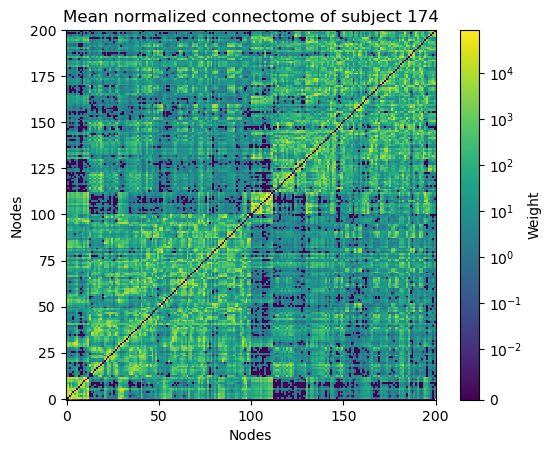

In [3]:
# Load sub-id connectome (200 parcels)
id = 174
path = f'/m/nbe/scratch/leap_mcpsych/derivatives/DTI/ses-01/kuramoto/clinical/all_subjects_add/sub-CON{id}_parcels_coreg_yeo17_200.csv'
sub = pd.read_csv(path, sep=',', header=None)
sc = sub / np.mean(sub)
sc = (np.array(sub)[:200, :200])
# Plot SC
plt.imshow(sc, origin = 'lower')
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.pcolormesh(sc, norm = mpl.colors.SymLogNorm(linthresh=0.01, vmin = np.min(sc), vmax = np.max(sc)))
plt.title(f'Mean normalized connectome of subject {id}')
plt.colorbar(label = 'Weight')
plt.show()

WHOLE NETWORK ANALYSIS

In [4]:
dfa_KL_orig = np.load('all_subjects_array/dfa_KL_orig.npy')
order_KL_orig = np.load('all_subjects_array/order_KL_orig.npy')
plv_KL_orig =  np.load('all_subjects_array/plv_KL_orig.npy')

print(order_KL_orig.shape)
print(plv_KL_orig.shape)
print(dfa_KL_orig.shape)

(230, 40, 1)
(230, 40, 1)
(230, 40, 1, 200)


In [4]:
peak_adj_dfa = np.load('all_subjects_array/peak_adj_dfa.npy')
peak_adj_order = np.load('all_subjects_array/peak_adj_order.npy')
peak_adj_plv = np.load('all_subjects_array/peak_adj_plv.npy')

print(peak_adj_order.shape)
print(peak_adj_plv.shape)
print(peak_adj_dfa.shape)

(230, 40, 1)
(230, 40, 1)
(230, 40, 1, 200)


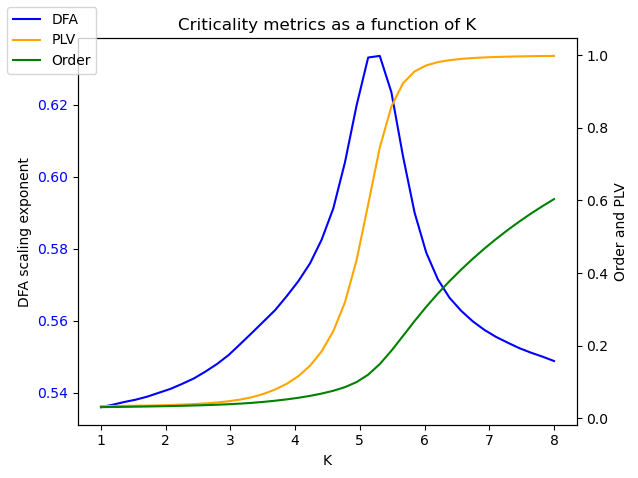

In [6]:
# RAW DFA DATA MEAN OVER SUBJECTS AND NODES
fig, ax1 = plt.subplots()

ks = np.linspace(1, 8, 40)
ax1.plot(ks, np.mean(dfa_KL_orig, axis=(0, -1)), label='DFA', color='blue')
ax1.set_xlabel('K')
ax1.set_ylabel('DFA scaling exponent')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()

ax2.plot(ks, np.mean(plv_KL_orig, axis=0), label='PLV', color='orange')
ax2.set_ylabel('PLV')
ax2.tick_params(axis='y')

ax2.plot(ks, np.mean(order_KL_orig, axis=0), label='Order', color='green')
ax2.set_ylabel('Order and PLV')
ax2.tick_params(axis='y')

#ax1.text(0.4, 0.85, 'Subcritical', transform=ax1.transAxes, color='red', fontsize=10, ha='center')
#ax1.text(0.80, 0.85, 'Supercritical', transform=ax1.transAxes, color='red', fontsize=10, ha='center')

plt.title('Criticality metrics as a function of K')
fig.tight_layout()
fig.legend(loc='upper left')
plt.show()

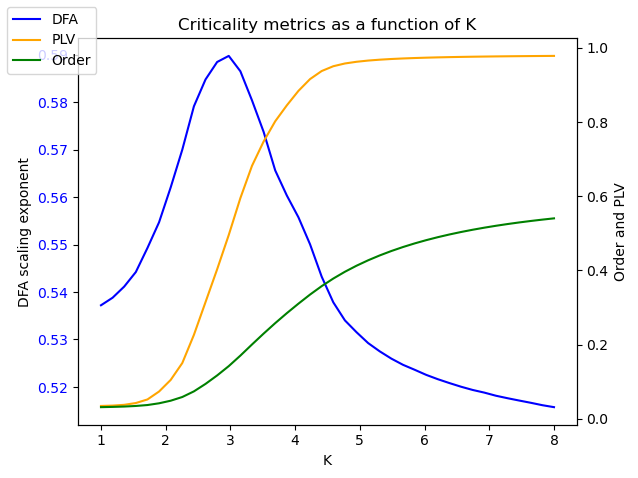

In [7]:
# PEAK K DFA DATA MEAN OVER SUBJECTS AND NODES
fig, ax1 = plt.subplots()

ks = np.linspace(1, 8, 40)
ax1.plot(ks, np.mean(peak_adj_dfa, axis=(0, -1)), label='DFA', color='blue')
ax1.set_xlabel('K')
ax1.set_ylabel('DFA scaling exponent')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()

ax2.plot(ks, np.mean(peak_adj_plv, axis=0), label='PLV', color='orange')
ax2.set_ylabel('PLV')
ax2.tick_params(axis='y')

ax2.plot(ks, np.mean(peak_adj_order, axis=0), label='Order', color='green')
ax2.set_ylabel('Order and PLV')
ax2.tick_params(axis='y')

#ax1.text(0.4, 0.85, 'Subcritical', transform=ax1.transAxes, color='red', fontsize=10, ha='center')
#ax1.text(0.80, 0.85, 'Supercritical', transform=ax1.transAxes, color='red', fontsize=10, ha='center')

plt.title('Criticality metrics as a function of K')
fig.tight_layout()
fig.legend(loc='upper left')
plt.show()

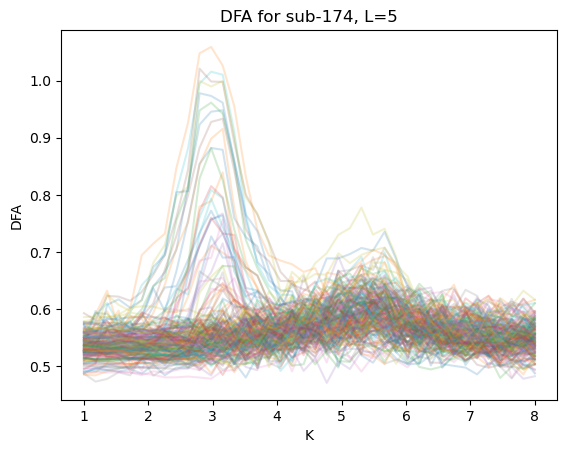

In [8]:
# RAW DFA DATA 
ks = np.linspace(1, 8, num=40)
ls = [5]
subject_index = 23
L_index = 0

plt.plot(ks, dfa_KL_orig[subject_index, :, L_index, :200], alpha=0.2)
plt.xlabel('K')
plt.ylabel('DFA')
plt.title(f'DFA for sub-{clinical_ids[subject_index]}, L={ls[L_index]}')
plt.show()

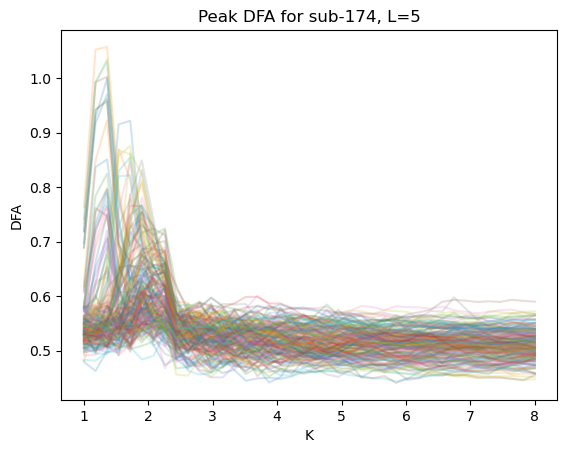

In [9]:
# PEAK K DFA DATA
ks = np.linspace(1, 8, num=40)
ls = [5]
subject_index = 23
L_index = 0

plt.plot(ks, peak_adj_dfa[subject_index, :, L_index, :200], alpha=0.2)
plt.xlabel('K')
plt.ylabel('DFA')
plt.title(f'Peak DFA for sub-{clinical_ids[subject_index]}, L={ls[L_index]}')
plt.show()

In [7]:
#clinical_ids = np.load('clinical_ids_all.npy')
clinical_ids_add = np.load('/m/nbe/scratch/leap_mcpsych/Samanta/kuramoto/clinical_ids_all_add.npy')
connectomes = []

for c_id in clinical_ids_add:
    subject_path = f"/m/nbe/scratch/leap_mcpsych/derivatives/DTI/ses-01/kuramoto/clinical/all_subjects_add/sub-CON{c_id}_parcels_coreg_yeo17_200.csv"
    subject = pd.read_csv(subject_path, sep=',', header=None)
    orig_sc = np.array(subject)[:200, :200]
    connectome_normed = orig_sc / orig_sc.mean()
    connectomes.append(connectome_normed)

connectomes_array = np.array(connectomes)
print(connectomes_array.shape)

(230, 200, 200)


In [8]:
# Convert SCs into networkx objects
networks = []

for connectome_normed in connectomes_array:
    network = nx.from_numpy_array(connectome_normed)
    networks.append(network) 
print(len(networks))

230


In [83]:
# Spectral dimension
def spectral_dimension(adj_matrix, threshold=0.5, min_points=10):
    assert np.allclose(adj_matrix, adj_matrix.T)
    
    # Compute the degree matrix
    degrees = np.sum(adj_matrix, axis=1)
    
    # Check for isolated nodes (degree zero)
    if np.any(degrees == 0):
        print("Warning: Isolated nodes found, adjusting the degrees.")
        degrees[degrees == 0] = 1  # Avoid division by zero
    
    # Compute the normalized Laplacian
    D_inv_sqrt = np.diag(1.0 / np.sqrt(degrees))
    L = np.eye(adj_matrix.shape[0]) - D_inv_sqrt @ adj_matrix @ D_inv_sqrt
    
    # Compute eigenvalues of the normalized Laplacian using dense matrix method
    eigenvalues = scipy.linalg.eigh(L, eigvals_only=True)
    eigenvalues = np.sort(eigenvalues)
    
    # Filter out non-positive eigenvalues to avoid log(0) or log(negative)
    eigenvalues = eigenvalues[eigenvalues > 1e-10]
    
    # Compute the cumulative distribution of eigenvalues
    rho_c = np.arange(1, len(eigenvalues) + 1) / len(eigenvalues)
    
    # Select eigenvalues less than the threshold
    small_lambda = eigenvalues[eigenvalues < threshold]
    small_rho_c = rho_c[:len(small_lambda)]
    
    # Ensure we have enough points to fit
    if len(small_lambda) < min_points:
        raise ValueError(f"Not enough small eigenvalues to fit the spectral dimension. Found {len(small_lambda)} points.")
    
    # Fit power law to the cumulative distribution for small lambda
    try:
        coeffs = np.polyfit(np.log(small_lambda), np.log(small_rho_c), 1)
        d_S = 2 * coeffs[0]
    except np.linalg.LinAlgError as e:
        raise RuntimeError("Fitting the spectral dimension failed: " + str(e))
    
    return d_S

connectomes = networks  

# Compute spectral dimensions for all connectomes
spectral_dimensions = []
for i, G in enumerate(connectomes):
    adj_matrix = nx.adjacency_matrix(G).todense()
    try:
        d_S = spectral_dimension(adj_matrix)
        spectral_dimensions.append(d_S)
    except ValueError as e:
        print(f"Subject {i}: {e}")
        spectral_dimensions.append(np.nan)  # Handle subjects with insufficient data

spectral_dimensions = np.array(spectral_dimensions)

print("Spectral Dimensions:", spectral_dimensions)


Spectral Dimensions: [2.98259792 2.82164463 2.99393199 2.96382416 2.93697433 2.98358824
 2.96613761 3.1757475  3.08868128 2.83352213 3.12700868 2.99075967
 3.35736753 3.11117272 3.35514009 2.86651617 3.16229191 2.73925081
 2.99193281 2.96467172 3.07096595 3.17451789 3.06831217 3.1036153
 3.2837253  2.85458971 2.85859984 2.92232943 3.20457609 3.08235345
 3.0136768  3.25549307 3.04701978 2.84210897 2.81929214 2.88841181
 3.15887489 2.84657325 2.95430832 2.84578046 2.65226668 3.1477896
 3.33127248 3.3031154  3.08374327 2.96334035 2.98772654 2.83906445
 3.19155829 3.35525421 3.00667017 2.94472601 3.27062466 2.94891933
 3.09987138 3.02463647 3.06458628 3.00707988 3.11545654 3.38697256
 3.04361139 2.98317574 2.69571254 2.97337784 2.68361307 2.92537944
 2.97507236 3.0399551  2.98467986 3.16119104 2.93912083 2.98199871
 2.8554132  2.9973724  3.0395614  2.96043499 3.14211757 3.02363095
 2.87669854 3.19786027 2.8985286  3.15356998 3.21486516 2.8745742
 3.07351773 2.91849063 2.88841289 2.82451078

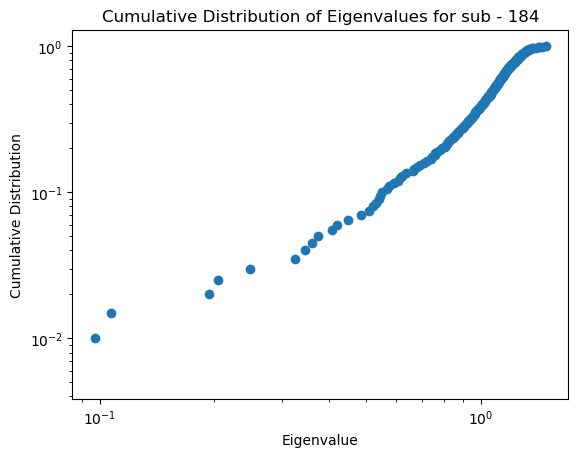

In [87]:
# Plot cumulative distribution for one example graph (replace index with any subject you want to visualize)
subject_index = 25
adj_matrix_example = nx.adjacency_matrix(connectomes[subject_index]).todense()
laplacian_example = np.eye(adj_matrix_example.shape[0]) - np.diag(1.0 / np.sqrt(np.sum(adj_matrix_example, axis=1))) @ adj_matrix_example @ np.diag(1.0 / np.sqrt(np.sum(adj_matrix_example, axis=1)))
eigenvalues_example = scipy.linalg.eigh(laplacian_example, eigvals_only=True)
eigenvalues_example = np.sort(eigenvalues_example)
rho_c_example = np.arange(1, len(eigenvalues_example) + 1) / len(eigenvalues_example)

plt.loglog(eigenvalues_example, rho_c_example, 'o')
plt.xlabel('Eigenvalue')
plt.ylabel('Cumulative Distribution')
plt.title(f'Cumulative Distribution of Eigenvalues for sub - {clinical_ids[subject_index]}')
plt.show()

In [73]:
import networkx as nx
import numpy as np
from scipy.optimize import curve_fit
from collections import Counter

def box_counting_coverage(graph, box_size):
    """
    Perform the box-counting algorithm on a graph with a specified box size.
    """
    covered = set()
    count = 0
    nodes = list(graph.nodes())
    np.random.shuffle(nodes)
    
    for node in nodes:
        if node not in covered:
            count += 1
            stack = [node]
            covered.add(node)
            while stack and len(stack) < box_size:
                current = stack.pop()
                for neighbor in graph.neighbors(current):
                    if neighbor not in covered:
                        stack.append(neighbor)
                        covered.add(neighbor)
                        if len(stack) >= box_size:
                            break
    return count

def fractal_dimension(graph):
    """
    Compute the fractal dimension of a graph using the box-counting algorithm.
    """
    box_sizes = [2, 4, 8, 16, 32, 64, 128, 200]
    counts = [box_counting_coverage(graph, size) for size in box_sizes]

    log_box_sizes = np.log(box_sizes)
    log_counts = np.log(counts)
    
    def linear_fit(x, a, b):
        return a * x + b

    popt, _ = curve_fit(linear_fit, log_box_sizes, log_counts)

    return -popt[0]

if __name__ == "__main__":
    np.random.seed(42)  # Ensure reproducibility
    
    connectomes = networks
    
    # Compute fractal dimensions for all connectomes
    fractal_dimensions = []
    for i, graph in enumerate(connectomes):
        fd = fractal_dimension(graph)
        fractal_dimensions.append(fd)
        print(f"Fractal Dimension for connectome {i}: {fd}")

    fractal_dimensions = np.array(fractal_dimensions)

    # Check for unique fractal dimensions
    dimension_counts = Counter(fractal_dimensions)
    for dimension, count in dimension_counts.items():
        print(f"Fractal Dimension: {dimension}, Count: {count}")

    # Print all fractal dimensions
    print(fractal_dimensions)


Fractal Dimension for connectome 0: 0.9287593039776104
Fractal Dimension for connectome 1: 0.9271083994639502
Fractal Dimension for connectome 2: 0.9063643564651729
Fractal Dimension for connectome 3: 0.911436935954642
Fractal Dimension for connectome 4: 0.9221606944647953
Fractal Dimension for connectome 5: 0.8654008650753111
Fractal Dimension for connectome 6: 0.9160889702792144
Fractal Dimension for connectome 7: 0.9179515147476045
Fractal Dimension for connectome 8: 0.9112700370478145
Fractal Dimension for connectome 9: 0.8946799663062915
Fractal Dimension for connectome 10: 0.9252160952442832
Fractal Dimension for connectome 11: 0.9198129701596359
Fractal Dimension for connectome 12: 0.9071291414856666
Fractal Dimension for connectome 13: 0.9181681625427899
Fractal Dimension for connectome 14: 0.8579377374758244
Fractal Dimension for connectome 15: 0.9183088778698263
Fractal Dimension for connectome 16: 0.8684962111632017
Fractal Dimension for connectome 17: 0.902436799495433
Frac

In [9]:
average_dd = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/average_dd.npy')
clustering_coefficients = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/clustering_coefficients.npy')
average_spl = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/average_spl.npy')
global_efficiency_values = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/global_efficiency_values.npy')
eigenvector_centralities = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/eigenvector_centralities.npy')
assortativity_coefficients = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/assortativity_coefficients.npy')
modularity_values = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/modularity_values.npy')
hierarchy_scores = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/hierarchy_scores.npy')
heterogeneity_scores = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/heterogeneity_scores.npy')
variance_sc = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/variance_sc.npy')
edge_connectivity = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/edge_connectivity.npy')
edge_load_centrality = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/edge_load_centrality.npy')
edge_between_centrality = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/edge_between_centrality.npy')
spectral_dimensions = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/spectral_dimensions.npy')
fractal_dimensions = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/fractal_dimensions.npy')

sc_properties = np.concatenate([average_dd, clustering_coefficients, average_spl, global_efficiency_values,
                                eigenvector_centralities, assortativity_coefficients, modularity_values,
                                hierarchy_scores, heterogeneity_scores, variance_sc, edge_connectivity, edge_load_centrality,
                                edge_between_centrality, spectral_dimensions, fractal_dimensions], axis=0)

sc_properties = sc_properties.reshape(15, -1)
print(sc_properties.shape)

(15, 230)


In [13]:
# Make a table of SC metrics for thesis
mean_sc_properties = np.mean(sc_properties, axis = 1)
sc_metric_names = ['Degree distribution', 'Average clustering coefficient', 'Average Shortest Path Length', 'Global Efficiency',
                'Eigenvector centrality', 'Assortativity coefficient', 'Modularity', 'Hierarchy score',
                'Heterogeneity score', 'Variance of SC', 'Edge connectivity', 'Edge load centrality', 'Edge betweenness centrality', 'Spectral Dimension', 'Fractal Dimension']
df = pd.DataFrame({'Name of SC property': sc_metric_names, 'Average of SC property': mean_sc_properties})
print(df)


               Name of SC property  Average of SC property
0              Degree distribution              181.497522
1   Average clustering coefficient                0.929141
2     Average Shortest Path Length                1.087952
3                Global Efficiency                0.956024
4           Eigenvector centrality                0.070434
5        Assortativity coefficient               -0.042008
6                       Modularity                0.304188
7                  Hierarchy score              -23.264174
8              Heterogeneity score                0.089862
9                   Variance of SC               19.576454
10               Edge connectivity              104.608696
11            Edge load centrality              226.172246
12     Edge betweenness centrality                0.000060
13              Spectral Dimension                3.014937
14               Fractal Dimension                0.904721


In [10]:
# Load the peak K RAW values for each subject
n_sub = 230
peak_k_data = []
for subject_index in range(n_sub):
    peak_k_data.append(np.load(f'/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/peak_ks_raw_array_230/peak_ks_subject_{subject_index}.npy'))

# Compute GP widths for each subject
threshold = 0.65
k_threshold = 8 # Threshold for last peak k
gp_widths = []
for peak_ks in peak_k_data:
    # Filter out the peak K values above the threshold
    peak_ks_above_threshold = peak_ks[peak_ks >= threshold]
    if len(peak_ks_above_threshold) < 2:
        gp_widths.append(np.nan)
        continue
    # Ensure last peak k comes before k=k_threshold
    last_peak_k = np.max(peak_ks_above_threshold)
    if last_peak_k >= k_threshold:
        peak_ks_before_threshold = peak_ks_above_threshold[peak_ks_above_threshold < k_threshold]
        if len(peak_ks_before_threshold) == 0:
            gp_widths.append(0)  # No peak k values below k_threshold
            continue
        last_peak_k = peak_ks_before_threshold[-1]
    # Compute the GP width
    gp_width = last_peak_k - np.min(peak_ks_above_threshold)
    gp_widths.append(gp_width)

df_gp_widths = pd.DataFrame({'gp_width': gp_widths})
df_gp_widths
# df_gp_widths.to_csv('gp_widths.csv', index=False)

,gp_width
0,2.692308
1,3.230769
2,2.871795
3,2.333333
4,4.128205
...,...
225,2.333333
226,2.333333
227,1.076923
228,2.692308


In [11]:
# Load the peak K values for each subject
n_sub = 230
peak_k_data = []
for subject_index in range(n_sub):
    peak_k_data.append(np.load(f'/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/peak_ks_array_230/peak_ks_subject_{subject_index}.npy'))

# Compute GP widths for each subject
threshold = 0.65
k_threshold = 6 # Threshold for last peak k
gp_widths_adj = []
for peak_ks in peak_k_data:
    # Filter out the peak K values above the threshold
    peak_ks_above_threshold = peak_ks[peak_ks >= threshold]
    if len(peak_ks_above_threshold) < 2:
        gp_widths.append(np.nan)
        continue
    # Ensure last peak k comes before k=k_threshold
    last_peak_k = np.max(peak_ks_above_threshold)
    if last_peak_k >= k_threshold:
        peak_ks_before_threshold = peak_ks_above_threshold[peak_ks_above_threshold < k_threshold]
        if len(peak_ks_before_threshold) == 0:
            gp_widths.append(0)  # No peak k values below k_threshold
            continue
        last_peak_k = peak_ks_before_threshold[-1]
    # Compute the GP width
    gp_width = last_peak_k - np.min(peak_ks_above_threshold)
    gp_widths_adj.append(gp_width)

df_gp_widths = pd.DataFrame({'gp_width': gp_widths_adj})
df_gp_widths
# df_gp_widths.to_csv('gp_widths.csv', index=False)

,gp_width
0,0.897436
1,1.256410
2,1.256410
3,1.794872
4,1.076923
...,...
225,0.717949
226,2.153846
227,0.717949
228,0.897436


(230,)
Synchronizability - 1.7852753800031642


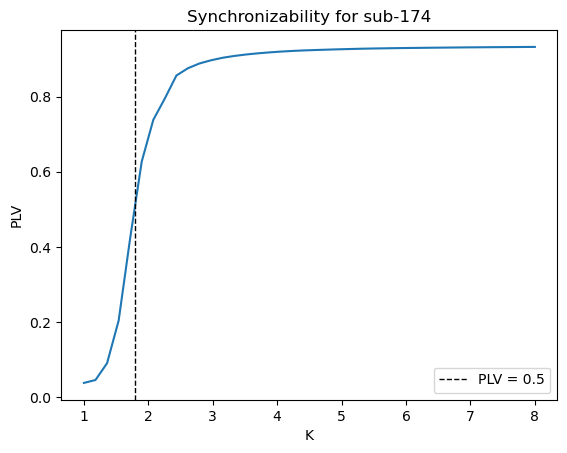

In [12]:
#Synchronizability = location of the critical ridge 
#(a ridge at smaller K & L values indicates greater synchronizability)

#plv_KL_orig.shape) shape is (subs,ks,ls)

synchronizabilities = []
ks = np.linspace(1,8,40)
plv_value = 0.5
for subject_index in range(peak_adj_plv.shape[0]):
    # Interpolate PLV values to get more accurate K-value where PLV = 0.5
    plv_interp_func = scipy.interpolate.interp1d(peak_adj_plv[subject_index, :, 0], ks, kind='linear')
    plv_ks = plv_interp_func(plv_value)
    synchronizabilities.append(plv_ks)
synchronizabilities = np.array(synchronizabilities)
print(synchronizabilities.shape)

subject_index = 23
ls = 5
ks = np.linspace(1, 8, num=40)


print(f"Synchronizability - {synchronizabilities[subject_index]}")

plt.plot(ks, peak_adj_plv[subject_index, :, 0])
plt.axvline(synchronizabilities[subject_index], color='black', linewidth=1, linestyle='--', label='PLV = 0.5')
plt.xlabel('K')
plt.ylabel('PLV')
plt.title(f'Synchronizability for sub-{clinical_ids[subject_index]}')
plt.legend()
plt.show()

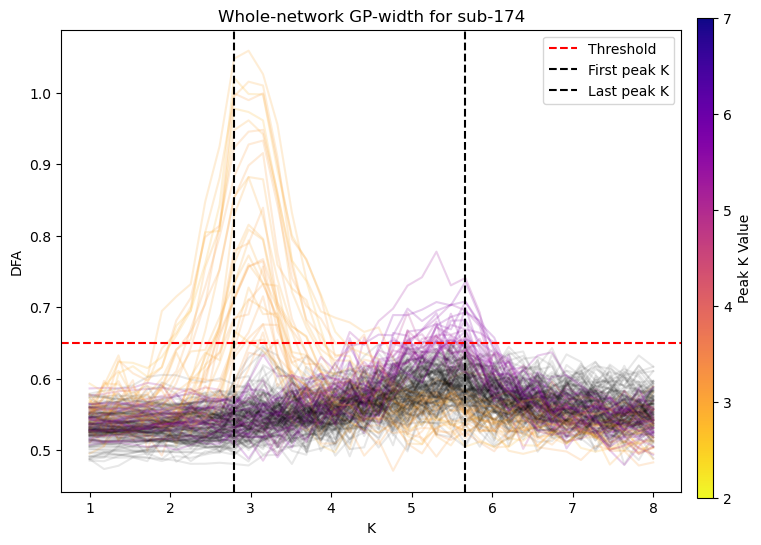

GP-width = 2.8717948717948723


In [17]:
# Plotting whole-network GP for RAW data
subject_index = 23
ks = np.linspace(1,8,40)
subject_data = dfa_KL_orig[subject_index, :, 0, :200]# Assuming 200 parcels
threshold = 0.65  # Define your threshold value here

max_dfa_indices = np.argmax(subject_data, axis=0)
peak_ks = ks[max_dfa_indices]
max_dfa_values = np.max(subject_data, axis=0)

filtered_peak_ks = peak_ks[max_dfa_values > threshold]
filtered_max_dfa_values = max_dfa_values[max_dfa_values > threshold]

cmap = plt.cm.plasma_r
norm = Normalize(vmin=2, vmax=7) 

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)  # Main plot axis
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Colorbar axis [left, bottom, width, height]

for parcel_index in range(subject_data.shape[1]):
    peak_k = peak_ks[parcel_index]
    peak_dfa = max_dfa_values[parcel_index]
    if peak_dfa >= threshold:
        ax.plot(ks, subject_data[:, parcel_index], color=cmap(norm(peak_k)), alpha=0.2)  # Use normalized K value for color
    else:
        ax.plot(ks, subject_data[:, parcel_index], color='black', alpha=0.09)  # Plot in gray if peak DFA is below threshold

ax.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
ax.axvline(x=np.min(filtered_peak_ks), color='black', linestyle='--', label='First peak K')
ax.axvline(x=np.max(filtered_peak_ks), color='black', linestyle='--', label='Last peak K')

ax.set_xlabel('K')  
ax.set_ylabel('DFA')
ax.set_title(f'Whole-network GP-width for sub-{clinical_ids[subject_index]}')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Peak K Value')

ax.legend()
plt.show()

print(f'GP-width = {gp_widths[subject_index]}')


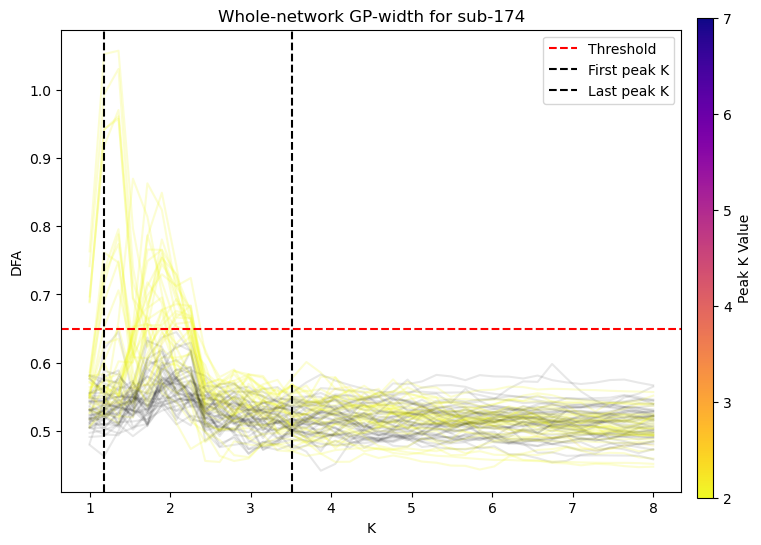

GP-width = 1.0769230769230769


In [18]:
k_threshold = 6
subject_index = 23
subject_data = peak_adj_dfa[subject_index, :, 0, :200]  # Assuming 200 parcels
threshold = 0.65  # Define your threshold value here

max_dfa_indices = np.argmax(subject_data, axis=0)
peak_ks = ks[max_dfa_indices]
max_dfa_values = np.max(subject_data, axis=0)

filtered_peak_ks = peak_ks[max_dfa_values > threshold]
filtered_max_dfa_values = max_dfa_values[max_dfa_values > threshold]

cmap = plt.cm.plasma_r
norm = Normalize(vmin=2, vmax=7)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)  # Main plot axis
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Colorbar axis [left, bottom, width, height]

# Sort nodes based on their peak K values in ascending order
sorted_indices = np.argsort(filtered_peak_ks)
sorted_peak_ks = filtered_peak_ks[sorted_indices]
sorted_max_dfa_values = filtered_max_dfa_values[sorted_indices]

# Plot all nodes using sorted indices
for parcel_index in sorted_indices:
    peak_k = peak_ks[parcel_index]
    peak_dfa = max_dfa_values[parcel_index]
    if peak_dfa >= threshold:
        ax.plot(ks, subject_data[:, parcel_index], color=cmap(norm(peak_k)), alpha=0.2)  # Use normalized K value for color
    else:
        ax.plot(ks, subject_data[:, parcel_index], color='black', alpha=0.09)  # Plot in gray if peak DFA is below threshold

# Find the index of the first peak k without using threshold
first_peak_k_index = sorted_indices[0]
last_peak_k_index = np.where(peak_ks < k_threshold)[0][-1]

ax.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
ax.axvline(x=peak_ks[first_peak_k_index], color='black', linestyle='--', label='First peak K')
ax.axvline(x=peak_ks[last_peak_k_index], color='black', linestyle='--', label='Last peak K')

ax.set_xlabel('K')
ax.set_ylabel('DFA')
ax.set_title(f'Whole-network GP-width for sub-{clinical_ids[subject_index]}')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Peak K Value')

ax.legend()
plt.show()

print(f'GP-width = {gp_widths_adj[subject_index]}')


In [14]:
# Graph-GP-width computation for every subject
graph_GP_widths = []
for sub_idx in range(len(gp_widths_subjects)):
    graph_GP = np.mean(gp_widths_subjects[sub_idx, :], axis=-1)
    graph_GP_widths.append(graph_GP)
graph_GP_widths = np.array(graph_GP_widths)
print(graph_GP_widths.shape)

(230,)


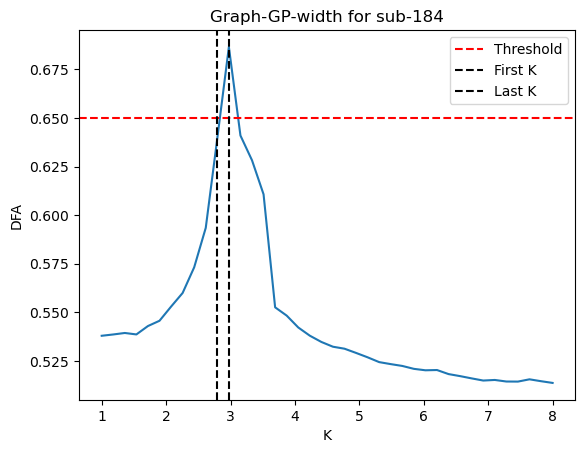

Graph-GP-width for sub-184 - 0.3266666666666667


In [15]:
# Graph-GP-width
sub_idx = 25
graph_GP = np.mean(gp_widths_subjects[sub_idx,:], axis = -1)
ks = np.linspace(1, 8, 40)
threshold = 0.65

mean_peak_dfa = np.mean(peak_adj_dfa, axis=-1)

k_indices = np.where(mean_peak_dfa[sub_idx] > threshold)[0]

first_k_index = k_indices[0]
last_k_index = k_indices[-1]

first_k_threshold = ks[first_k_index-1]
last_k_threshold = ks[last_k_index]

plt.plot(ks, mean_peak_dfa[sub_idx])
plt.xlabel('K')
plt.ylabel('DFA')
plt.title(f'Graph-GP-width for sub-{clinical_ids[sub_idx]}')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axvline(x=first_k_threshold, color='black', linestyle='--', label='First K')
plt.axvline(x=last_k_threshold, color='black', linestyle='--', label='Last K')
plt.legend()
plt.show()

difference = last_k_threshold - first_k_threshold
print(f"Graph-GP-width for sub-{clinical_ids[sub_idx]} -", graph_GP)

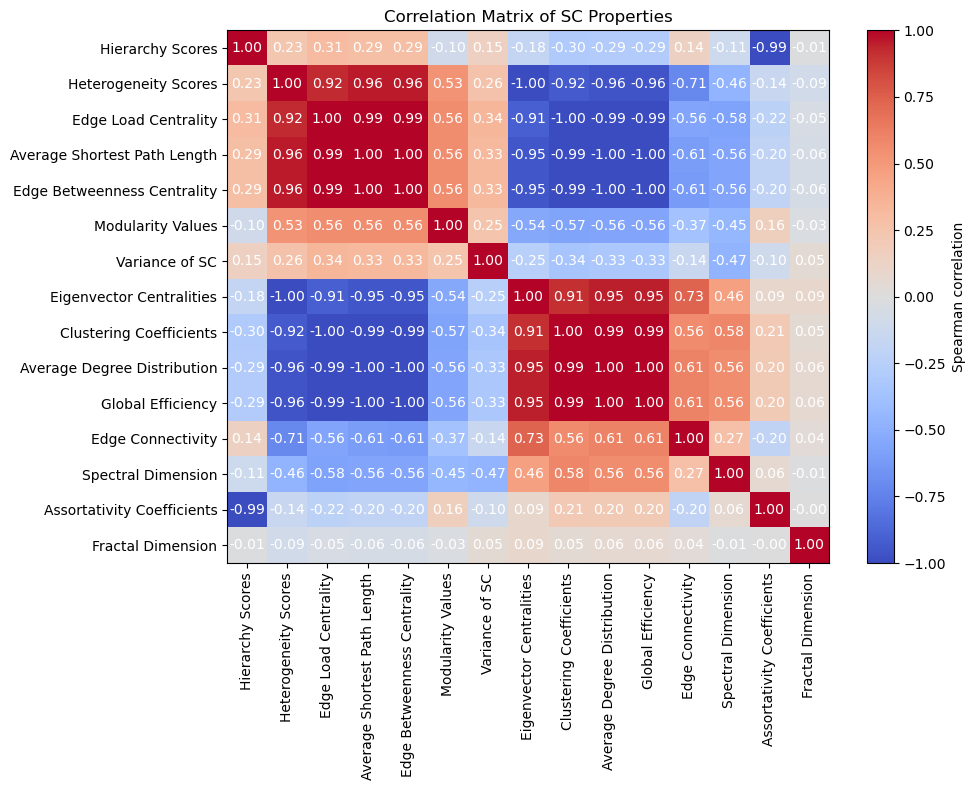

In [16]:
sc_property_matrix, p_values = scipy.stats.spearmanr(sc_properties, axis=1)

sc_property_names = [
    "Average Degree Distribution",
    "Clustering Coefficients",
    "Average Shortest Path Length",
    "Global Efficiency",
    "Eigenvector Centralities",
    "Assortativity Coefficients",
    "Modularity Values",
    "Hierarchy Scores",
    "Heterogeneity Scores",
    "Variance of SC",
    "Edge Connectivity",
    "Edge Load Centrality",
    "Edge Betweenness Centrality",
    "Spectral Dimension",
    "Fractal Dimension"
]

# Compute hierarchical clustering
linkage_matrix = scipy.cluster.hierarchy.linkage(sc_property_matrix, method='average')

# Reorder rows and columns of the correlation matrix based on clustering
order = scipy.cluster.hierarchy.leaves_list(linkage_matrix)
sorted_sc_property_matrix = sc_property_matrix[:, order][order, :]

# Plot the sorted correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(sorted_sc_property_matrix, cmap='coolwarm', aspect='auto')

# Add correlation values to the matrix
for i in range(sorted_sc_property_matrix.shape[0]):
    for j in range(sorted_sc_property_matrix.shape[1]):
        plt.text(j, i, "{:.2f}".format(sorted_sc_property_matrix[i, j]),
                 ha="center", va="center", color="w")

plt.colorbar(label='Spearman correlation')
plt.title('Correlation Matrix of SC Properties')
plt.xticks(ticks=np.arange(len(sc_property_names)), labels=np.array(sc_property_names)[order], rotation=90)
plt.yticks(ticks=np.arange(len(sc_property_names)), labels=np.array(sc_property_names)[order])
plt.tight_layout()
plt.show()


Spearman correlation between spectral dimension and variance: -0.46739487965992615


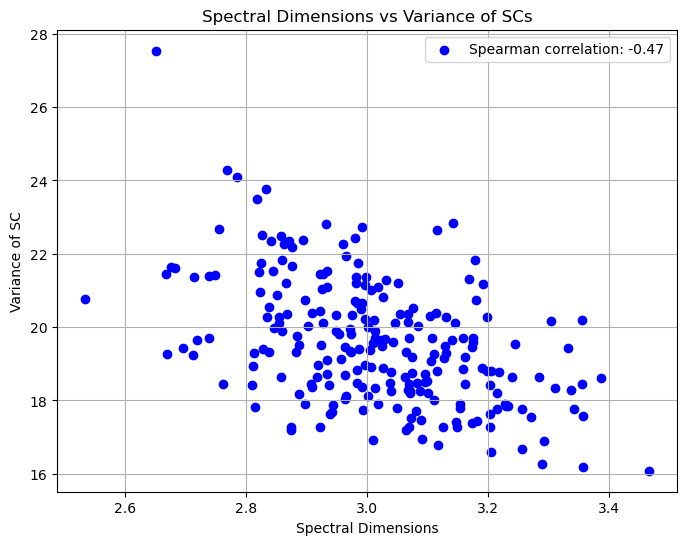

In [17]:
correlation_spectral_variance, _ = scipy.stats.spearmanr(spectral_dimensions, variance_sc)

print(f"Spearman correlation between spectral dimension and variance: {correlation_spectral_variance}")

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(spectral_dimensions, variance_sc, c='blue', label=f'Spearman correlation: {correlation_spectral_variance:.2f}')
plt.xlabel('Spectral Dimensions')
plt.ylabel('Variance of SC')
plt.title('Spectral Dimensions vs Variance of SCs')
plt.legend()
plt.grid(True)
plt.show()

Spearman correlation between spectral dimension and variance: 0.052392389860019456


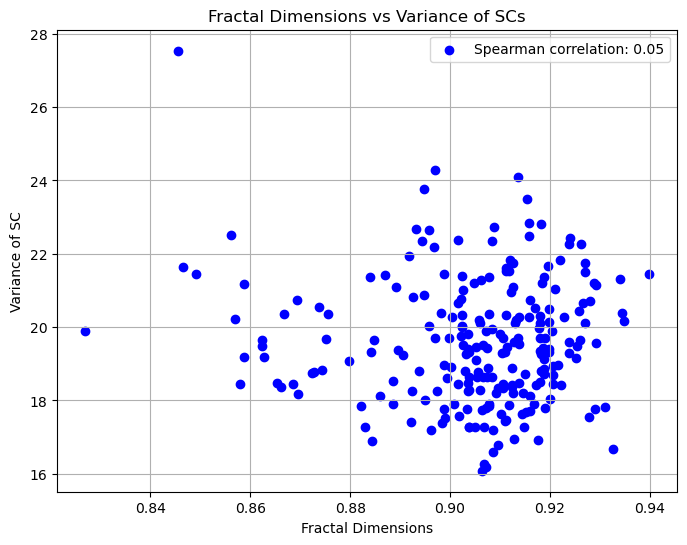

In [18]:
correlation_fractal_variance, _ = scipy.stats.spearmanr(fractal_dimensions, variance_sc)

print(f"Spearman correlation between spectral dimension and variance: {correlation_fractal_variance}")

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(fractal_dimensions, variance_sc, c='blue', label=f'Spearman correlation: {correlation_fractal_variance:.2f}')
plt.xlabel('Fractal Dimensions')
plt.ylabel('Variance of SC')
plt.title('Fractal Dimensions vs Variance of SCs')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
import statsmodels.api as sm

def partial_corr(x, y, control):
    model_y = sm.OLS(y, sm.add_constant(control)).fit()
    resid_y = model_y.resid
    model_x = sm.OLS(x, sm.add_constant(control)).fit()
    resid_x = model_x.resid
    partial_corr_value = np.corrcoef(resid_x, resid_y)[0, 1]
    return partial_corr_value

partial_corr_gp_widths_var = partial_corr(gp_widths_adj, variance_sc, spectral_dimensions)
partial_corr_gp_widths_spec = partial_corr(gp_widths_adj, spectral_dimensions, variance_sc)
partial_corr_graph_gp_widths_var = partial_corr(graph_GP_widths, variance_sc, spectral_dimensions)
partial_corr_graph_gp_widths_spec = partial_corr(graph_GP_widths, spectral_dimensions, variance_sc)

print("Partial correlations of SC variance and spectral dimension:\n")
print(f"Whole network GP-width vs Variance: {partial_corr_gp_widths_var}")
print(f"Whole network GP-width vs Spectral Dimension: {partial_corr_gp_widths_spec}")
print(f"Graph GP-width vs Variance: {partial_corr_graph_gp_widths_var}")
print(f"Graph GP-width vs Spectral Dimension: {partial_corr_graph_gp_widths_spec}")

Partial correlations of SC variance and spectral dimension:

Whole network GP-width vs Variance: 0.23182863805417864
Whole network GP-width vs Spectral Dimension: -0.054080854182785
Graph GP-width vs Variance: 0.25662601631190446
Graph GP-width vs Spectral Dimension: -0.3918827319344087


In [20]:
import statsmodels.api as sm

def partial_corr(x, y, control):
    model_y = sm.OLS(y, sm.add_constant(control)).fit()
    resid_y = model_y.resid
    model_x = sm.OLS(x, sm.add_constant(control)).fit()
    resid_x = model_x.resid
    partial_corr_value = np.corrcoef(resid_x, resid_y)[0, 1]
    return partial_corr_value

partial_corr_gp_widths_var = partial_corr(gp_widths_adj, variance_sc, fractal_dimensions)
partial_corr_gp_widths_frac = partial_corr(gp_widths_adj, fractal_dimensions, variance_sc)
partial_corr_graph_gp_widths_var = partial_corr(graph_GP_widths, variance_sc, fractal_dimensions)
partial_corr_graph_gp_widths_frac = partial_corr(graph_GP_widths, fractal_dimensions, variance_sc)

print("Partial correlations of SC variance and fractal dimension:\n")
print(f"Whole network GP-width vs Variance: {partial_corr_gp_widths_var}")
print(f"Whole network GP-width vs Fractal Dimension: {partial_corr_gp_widths_frac}")
print(f"Graph GP-width vs Variance: {partial_corr_graph_gp_widths_var}")
print(f"Graph GP-width vs Fractal Dimension: {partial_corr_graph_gp_widths_frac}")

Partial correlations of SC variance and fractal dimension:

Whole network GP-width vs Variance: 0.2929421764178875
Whole network GP-width vs Fractal Dimension: 0.04123723786698565
Graph GP-width vs Variance: 0.4466920846729982
Graph GP-width vs Fractal Dimension: -0.07532520381286685


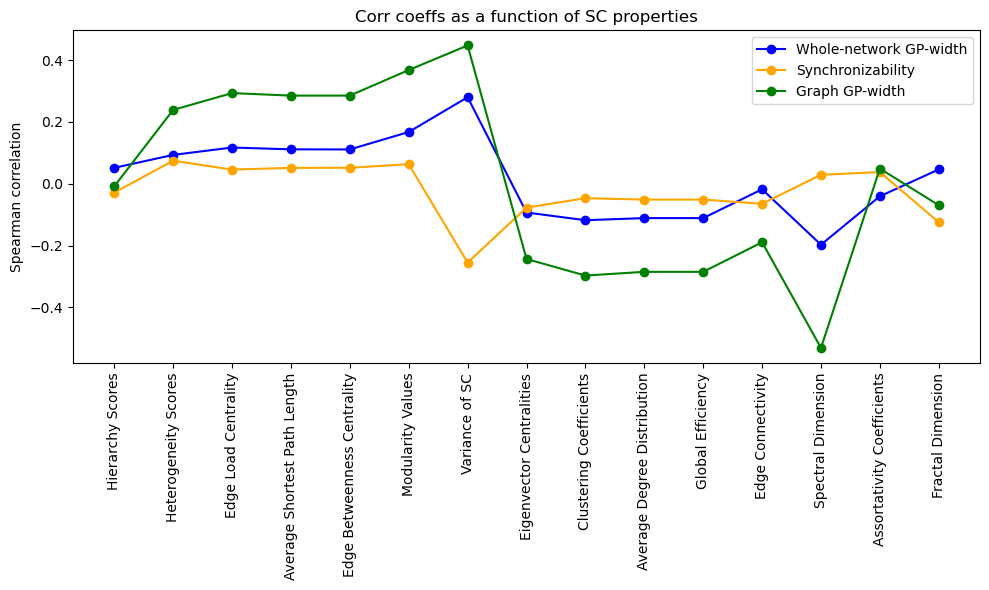

In [22]:
gp_widths =  gp_widths_adj  
synchronizability = synchronizabilities
graph_gp_widths = graph_GP_widths

correlations_gp_widths = [scipy.stats.spearmanr(sc_property, gp_widths)[0] for sc_property in sc_properties]
correlations_graph_gp_widths = [scipy.stats.spearmanr(sc_property, graph_gp_widths)[0] for sc_property in sc_properties]
correlations_synchronizability = [scipy.stats.spearmanr(sc_property, synchronizability)[0] for sc_property in sc_properties]

# Compute hierarchical clustering for SC properties
linkage_matrix = scipy.cluster.hierarchy.linkage(sc_property_matrix, method='average')
order = scipy.cluster.hierarchy.leaves_list(linkage_matrix)

# Sort correlations based on the clustering order
sorted_correlations_gp_widths = [correlations_gp_widths[i] for i in order]
sorted_correlations_graph_gp_widths = [correlations_graph_gp_widths[i] for i in order]
sorted_correlations_synchronizability = [correlations_synchronizability[i] for i in order]

plt.figure(figsize=(10, 6))

plt.plot(sorted_correlations_gp_widths, marker='o', label='Whole-network GP-width', color='blue')
plt.plot(sorted_correlations_synchronizability, marker='o', label='Synchronizability', color='orange')
plt.plot(sorted_correlations_graph_gp_widths, marker='o', label='Graph GP-width', color='green')

plt.title('Corr coeffs as a function of SC properties')
plt.ylabel('Spearman correlation')
plt.xticks(ticks=np.arange(len(sc_property_names)), labels=np.array(sc_property_names)[order], rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


In [39]:
'''for i, correlation in enumerate(correlations_gp_widths):
    sc_property_name = sc_property_names[i]
    np.save(f'correlation_data/gp_widths_{sc_property_name}.npy', correlation)

for i, correlation in enumerate(correlations_graph_gp_widths):
    sc_property_name = sc_property_names[i]
    np.save(f'correlation_data/graph_gp_widths_{sc_property_name}.npy', correlation)

for i, correlation in enumerate(correlations_synchronizability):
    sc_property_name = sc_property_names[i]
    np.save(f'correlation_data/synchronizability_{sc_property_name}.npy', correlation)'''


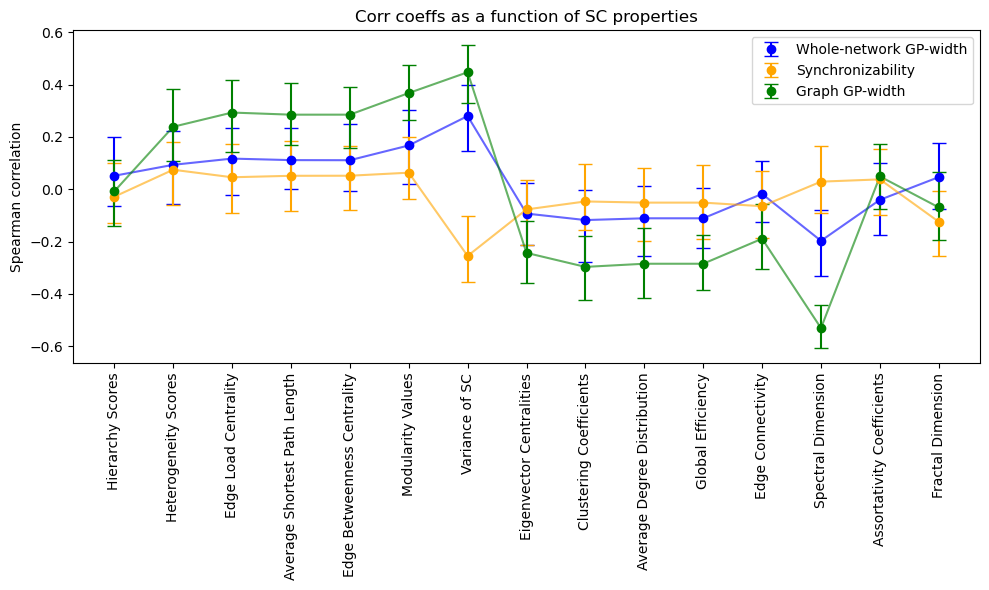

In [33]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

# Your existing data and calculations here...

# Convert lists to numpy arrays for proper indexing
gp_widths = np.array(gp_widths)
synchronizability = np.array(synchronizability)
graph_gp_widths = np.array(graph_gp_widths)

def bootstrap_ci(data1, data2, n_bootstraps=200, ci_percentile=95):
    n = len(data1)
    bootstrapped_corrs = []
    for _ in range(n_bootstraps):
        indices = np.random.choice(np.arange(n), size=n, replace=True)
        sample1 = data1[indices]
        sample2 = data2[indices]
        corr = scipy.stats.spearmanr(sample1, sample2)[0]
        bootstrapped_corrs.append(corr)
    
    lower_bound = np.percentile(bootstrapped_corrs, (100 - ci_percentile) / 2)
    upper_bound = np.percentile(bootstrapped_corrs, 100 - (100 - ci_percentile) / 2)
    return lower_bound, upper_bound

# Compute correlations and confidence intervals
correlations_gp_widths = []
correlations_gp_widths_ci = []
correlations_graph_gp_widths = []
correlations_graph_gp_widths_ci = []
correlations_synchronizability = []
correlations_synchronizability_ci = []

for sc_property in sc_properties:
    sc_property = np.array(sc_property)  # Convert to numpy array for proper indexing
    corr_gp_widths = scipy.stats.spearmanr(sc_property, gp_widths)[0]
    ci_gp_widths = bootstrap_ci(sc_property, gp_widths)
    correlations_gp_widths.append(corr_gp_widths)
    correlations_gp_widths_ci.append(ci_gp_widths)
    
    corr_graph_gp_widths = scipy.stats.spearmanr(sc_property, graph_gp_widths)[0]
    ci_graph_gp_widths = bootstrap_ci(sc_property, graph_gp_widths)
    correlations_graph_gp_widths.append(corr_graph_gp_widths)
    correlations_graph_gp_widths_ci.append(ci_graph_gp_widths)
    
    corr_synchronizability = scipy.stats.spearmanr(sc_property, synchronizability)[0]
    ci_synchronizability = bootstrap_ci(sc_property, synchronizability)
    correlations_synchronizability.append(corr_synchronizability)
    correlations_synchronizability_ci.append(ci_synchronizability)

# Compute hierarchical clustering for SC properties
linkage_matrix = linkage(sc_property_matrix, method='average')
order = leaves_list(linkage_matrix)

# Sort correlations and confidence intervals based on the clustering order
sorted_correlations_gp_widths = [correlations_gp_widths[i] for i in order]
sorted_correlations_gp_widths_ci = [correlations_gp_widths_ci[i] for i in order]
sorted_correlations_graph_gp_widths = [correlations_graph_gp_widths[i] for i in order]
sorted_correlations_graph_gp_widths_ci = [correlations_graph_gp_widths_ci[i] for i in order]
sorted_correlations_synchronizability = [correlations_synchronizability[i] for i in order]
sorted_correlations_synchronizability_ci = [correlations_synchronizability_ci[i] for i in order]

plt.figure(figsize=(10, 6))

# Plot with error bars
plt.errorbar(range(len(sorted_correlations_gp_widths)), sorted_correlations_gp_widths, 
             yerr=np.abs(np.array(sorted_correlations_gp_widths_ci).T - np.array(sorted_correlations_gp_widths)), 
             fmt='o', label='Whole-network GP-width', color='blue', capsize=5)
plt.errorbar(range(len(sorted_correlations_synchronizability)), sorted_correlations_synchronizability, 
             yerr=np.abs(np.array(sorted_correlations_synchronizability_ci).T - np.array(sorted_correlations_synchronizability)), 
             fmt='o', label='Synchronizability', color='orange', capsize=5)
plt.errorbar(range(len(sorted_correlations_graph_gp_widths)), sorted_correlations_graph_gp_widths, 
             yerr=np.abs(np.array(sorted_correlations_graph_gp_widths_ci).T - np.array(sorted_correlations_graph_gp_widths)), 
             fmt='o', label='Graph GP-width', color='green', capsize=5)

# Plot the lines
plt.plot(range(len(sorted_correlations_gp_widths)), sorted_correlations_gp_widths, color='blue', alpha=0.6)
plt.plot(range(len(sorted_correlations_synchronizability)), sorted_correlations_synchronizability, color='orange', alpha=0.6)
plt.plot(range(len(sorted_correlations_graph_gp_widths)), sorted_correlations_graph_gp_widths, color='green', alpha=0.6)

plt.title('Corr coeffs as a function of SC properties')
plt.ylabel('Spearman correlation')
plt.xticks(ticks=np.arange(len(sc_property_names)), labels=np.array(sc_property_names)[order], rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


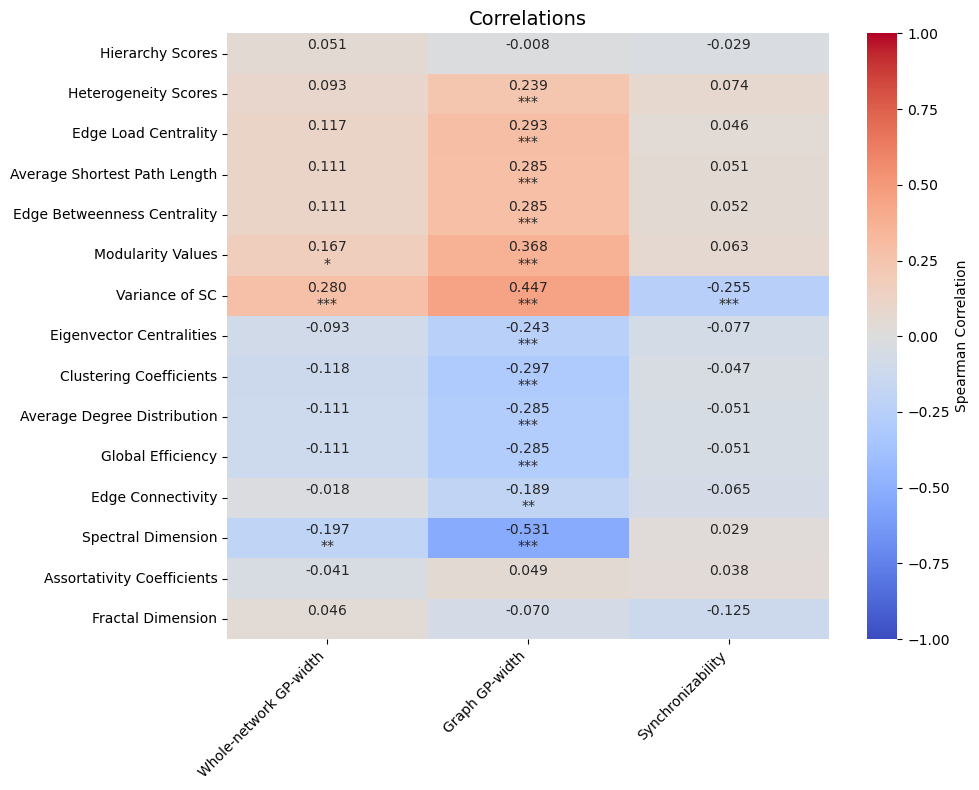

In [59]:
# Corr matrix
def get_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Compute correlations, p-values, and significance stars
correlations = []
p_values = []
stars = []

for sc_property in sc_properties:
    sc_property = np.array(sc_property)  # Convert to numpy array for proper indexing
    
    corr_gp_widths, p_gp_widths = scipy.stats.spearmanr(sc_property, gp_widths)
    corr_graph_gp_widths, p_graph_gp_widths = scipy.stats.spearmanr(sc_property, graph_gp_widths)
    corr_synchronizability, p_synchronizability = scipy.stats.spearmanr(sc_property, synchronizability)
    
    correlations.append([corr_gp_widths, corr_graph_gp_widths, corr_synchronizability])
    p_values.append([p_gp_widths, p_graph_gp_widths, p_synchronizability])
    stars.append([get_significance_stars(p_gp_widths), get_significance_stars(p_graph_gp_widths), get_significance_stars(p_synchronizability)])

correlation_matrix = np.array(correlations)
star_matrix = np.array(stars)

# Compute hierarchical clustering for SC properties
linkage_matrix = linkage(sc_property_matrix, method='average')
order = leaves_list(linkage_matrix)

# Sort the correlation matrix, star matrix, and property names based on the clustering order
sorted_correlation_matrix = correlation_matrix[order, :]
sorted_star_matrix = star_matrix[order, :]
sorted_sc_property_names = np.array(sc_property_names)[order]

# Create annotation labels combining correlation coefficients and significance stars
annot = np.empty_like(sorted_correlation_matrix, dtype=object)
for i in range(sorted_correlation_matrix.shape[0]):
    for j in range(sorted_correlation_matrix.shape[1]):
        annot[i, j] = f'{sorted_correlation_matrix[i, j]:.3f}\n{sorted_star_matrix[i, j]}'

plt.figure(figsize=(10, 8))
sns.heatmap(sorted_correlation_matrix, annot=annot, fmt='', cmap='coolwarm', xticklabels=['Whole-network GP-width', 'Graph GP-width', 'Synchronizability'], yticklabels=sorted_sc_property_names, cbar_kws={'label': 'Spearman Correlation'}, vmin=-1, vmax=1)

plt.title('Correlations', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# Compute partial correlations with pingouin
'''partial_corr_gp_widths = [pg.partial_corr(x=sc_property, y=gp_widths, covar=other_properties, method='spearman').r for sc_property in sc_properties]
partial_corr_graph_gp_widths = [pg.partial_corr(x=sc_property, y=graph_gp_widths, covar=other_properties, method='spearman').r for sc_property in sc_properties]
partial_corr_synchronizability = [pg.partial_corr(x=sc_property, y=synchronizability, covar=other_properties, method='spearman').r for sc_property in sc_properties]'''

In [41]:
# Compute partial correlations
import statsmodels.api as sm

def partial_corr(x, y, control):
    model_y = sm.OLS(y, sm.add_constant(control)).fit()
    resid_y = model_y.resid
    model_x = sm.OLS(x, sm.add_constant(control)).fit()
    resid_x = model_x.resid
    partial_corr_value = np.corrcoef(resid_x, resid_y)[0, 1]
    return partial_corr_value

partial_corr_gp_widths = []
partial_corr_graph_gp_widths = []
partial_corr_synchronizability = []

for i in range(sc_properties.shape[0]):
    control_properties = np.delete(sc_properties, i, axis=0)
    control_properties = np.transpose(control_properties)
    partial_corr_gp_widths.append(partial_corr(sc_properties[i], gp_widths, control_properties))
    partial_corr_graph_gp_widths.append(partial_corr(sc_properties[i], graph_gp_widths, control_properties))
    partial_corr_synchronizability.append(partial_corr(sc_properties[i], synchronizability, control_properties))


In [42]:
print("Partial Correlations with Whole-network GP-widths:")
for i, corr in enumerate(partial_corr_gp_widths):
    print(f"{sc_property_names[i]}: {corr}")

Partial Correlations with Whole-network GP-widths:
Average Degree Distribution: 6.285784797278877e-05
Clustering Coefficients: -0.1375114059173661
Average Shortest Path Length: 0.00029937323482327505
Global Efficiency: -0.002994860405538814
Eigenvector Centralities: -0.02382898588987597
Assortativity Coefficients: -0.10522124177549572
Modularity Values: 0.0636974726086702
Hierarchy Scores: -0.05364536932737617
Heterogeneity Scores: -0.00348526557832686
Variance of SC: 0.2769437560737255
Edge Connectivity: 0.06803820564341907
Edge Load Centrality: -0.14843566841346767
Edge Betweenness Centrality: -0.12067214618579272
Spectral Dimension: -0.03935389415200379
Fractal Dimension: 0.008466758571595779


In [43]:
print("\nPartial Correlations with Graph-GP-widths:")
for i, corr in enumerate(partial_corr_graph_gp_widths):
    print(f"{sc_property_names[i]}: {corr}")


Partial Correlations with Graph-GP-widths:
Average Degree Distribution: 0.0006796074087930885
Clustering Coefficients: -0.11997163058084942
Average Shortest Path Length: 0.00046216756110731673
Global Efficiency: -0.007704099370098602
Eigenvector Centralities: -0.03295393609957361
Assortativity Coefficients: -0.034446408498110044
Modularity Values: 0.1522894783803297
Hierarchy Scores: 0.07649881799399383
Heterogeneity Scores: -0.14391875076058597
Variance of SC: 0.2701479612609256
Edge Connectivity: -0.0404555016622024
Edge Load Centrality: -0.18089104543905213
Edge Betweenness Centrality: -0.1799598331457854
Spectral Dimension: -0.2944819910024516
Fractal Dimension: -0.10081232147797438


In [44]:
print("\nPartial Correlations with Synchronizability:")
for i, corr in enumerate(partial_corr_synchronizability):
    print(f"{sc_property_names[i]}: {corr}")


Partial Correlations with Synchronizability:
Average Degree Distribution: 0.0010996990229379963
Clustering Coefficients: 0.022188880212276756
Average Shortest Path Length: 7.876753619290407e-05
Global Efficiency: -0.004886270358676262
Eigenvector Centralities: -0.04512591946181165
Assortativity Coefficients: -0.0035699033126802716
Modularity Values: 0.029193479551011495
Hierarchy Scores: 0.010364766677936715
Heterogeneity Scores: -0.1047758591289374
Variance of SC: -0.284679756789916
Edge Connectivity: -0.04227237767082677
Edge Load Centrality: -0.00371418024267107
Edge Betweenness Centrality: -0.03259944752826536
Spectral Dimension: -0.0339703651588525
Fractal Dimension: -0.09141263904371957


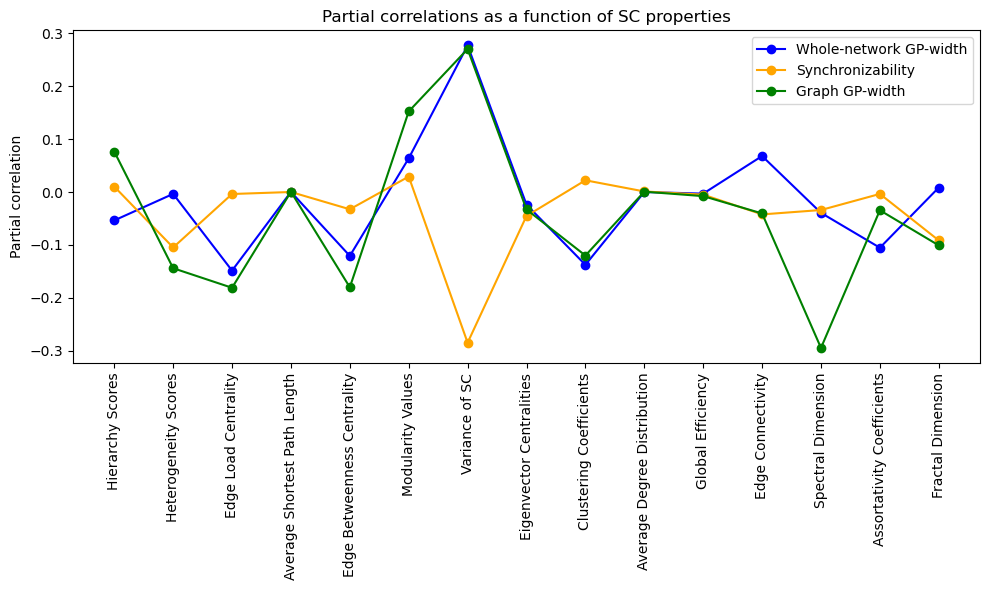

In [45]:
# Plot partial correlations with hierarchical clustering

# Compute hierarchical clustering for SC properties
linkage_matrix = scipy.cluster.hierarchy.linkage(sc_property_matrix, method='average')
order = scipy.cluster.hierarchy.leaves_list(linkage_matrix)

# Sort correlations based on the clustering order
par_sorted_correlations_gp_widths = [partial_corr_gp_widths[i] for i in order]
par_sorted_correlations_graph_gp_widths = [partial_corr_graph_gp_widths[i] for i in order]
par_sorted_correlations_synchronizability = [partial_corr_synchronizability[i] for i in order]

plt.figure(figsize=(10, 6))

plt.plot(par_sorted_correlations_gp_widths, marker='o', label='Whole-network GP-width', color='blue')
plt.plot(par_sorted_correlations_synchronizability, marker='o', label='Synchronizability', color='orange')
plt.plot(par_sorted_correlations_graph_gp_widths, marker='o', label='Graph GP-width', color='green')

plt.title('Partial correlations as a function of SC properties')
plt.ylabel('Partial correlation')
plt.xticks(ticks=np.arange(len(sc_property_names)), labels=np.array(sc_property_names)[order], rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


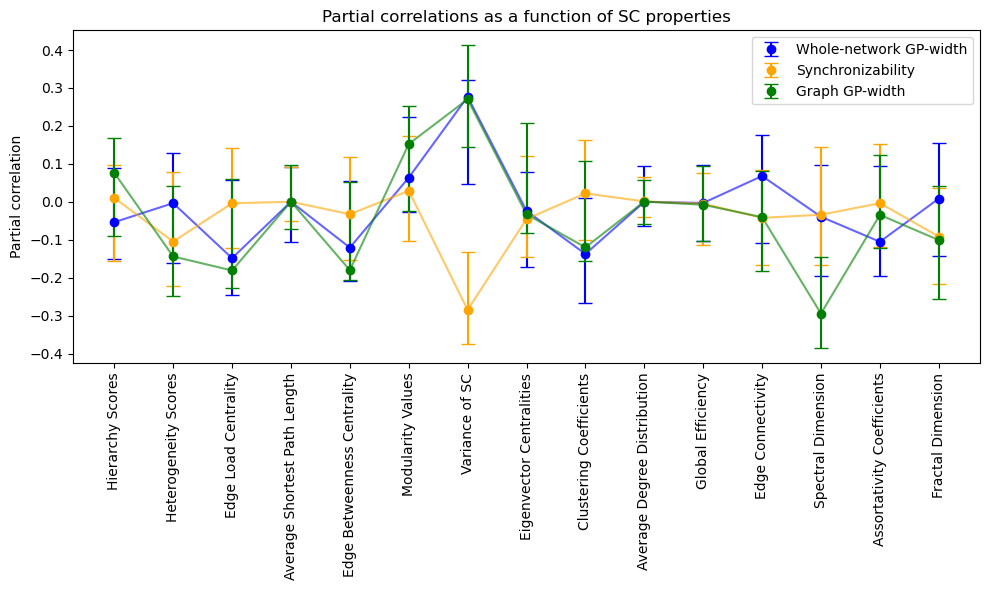

In [50]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

# Prepare control properties by excluding the property to be controlled for
def get_control_properties(properties, exclude_idx):
    control_properties = np.delete(properties, exclude_idx, axis=0)
    return np.transpose(control_properties)

# Convert lists to numpy arrays for proper indexing if needed
partial_corr_gp_widths = np.array(partial_corr_gp_widths)
partial_corr_graph_gp_widths = np.array(partial_corr_graph_gp_widths)
partial_corr_synchronizability = np.array(partial_corr_synchronizability)

# Define a function to compute partial Spearman correlation
def partial_spearmanr(x, y, control):
    # Residualize x and y with respect to control
    control = np.atleast_2d(control)
    control = np.concatenate([np.ones((control.shape[0], 1)), control], axis=1)
    
    beta_x = np.linalg.lstsq(control, x, rcond=None)[0]
    beta_y = np.linalg.lstsq(control, y, rcond=None)[0]
    
    x_resid = x - control @ beta_x
    y_resid = y - control @ beta_y
    
    # Compute Spearman correlation on residuals
    return scipy.stats.spearmanr(x_resid, y_resid)[0]

# Define a function to compute bootstrap confidence intervals for partial correlations
def bootstrap_ci(data1, data2, control, n_bootstraps=200, ci_percentile=95):
    n = len(data1)
    bootstrapped_corrs = []
    for _ in range(n_bootstraps):
        indices = np.random.choice(np.arange(n), size=n, replace=True)
        sample1 = data1[indices]
        sample2 = data2[indices]
        sample_control = control[indices]
        partial_corr = partial_spearmanr(sample1, sample2, sample_control)
        bootstrapped_corrs.append(partial_corr)
    
    lower_bound = np.percentile(bootstrapped_corrs, (100 - ci_percentile) / 2)
    upper_bound = np.percentile(bootstrapped_corrs, 100 - (100 - ci_percentile) / 2)
    return lower_bound, upper_bound

# Compute correlations and confidence intervals
partial_corr_gp_widths_ci = []
partial_corr_graph_gp_widths_ci = []
partial_corr_synchronizability_ci = []

for i, sc_property in enumerate(sc_properties):
    sc_property = np.array(sc_property)  # Convert to numpy array for proper indexing
    control_properties = get_control_properties(sc_properties, i)
    
    ci_gp_widths = bootstrap_ci(sc_property, gp_widths, control_properties)
    partial_corr_gp_widths_ci.append(ci_gp_widths)
    
    ci_graph_gp_widths = bootstrap_ci(sc_property, graph_gp_widths, control_properties)
    partial_corr_graph_gp_widths_ci.append(ci_graph_gp_widths)
    
    ci_synchronizability = bootstrap_ci(sc_property, synchronizability, control_properties)
    partial_corr_synchronizability_ci.append(ci_synchronizability)

# Compute hierarchical clustering for SC properties
linkage_matrix = linkage(sc_property_matrix, method='average')
order = leaves_list(linkage_matrix)

# Sort correlations and confidence intervals based on the clustering order
par_sorted_correlations_gp_widths = [partial_corr_gp_widths[i] for i in order]
par_sorted_correlations_gp_widths_ci = [partial_corr_gp_widths_ci[i] for i in order]
par_sorted_correlations_graph_gp_widths = [partial_corr_graph_gp_widths[i] for i in order]
par_sorted_correlations_graph_gp_widths_ci = [partial_corr_graph_gp_widths_ci[i] for i in order]
par_sorted_correlations_synchronizability = [partial_corr_synchronizability[i] for i in order]
par_sorted_correlations_synchronizability_ci = [partial_corr_synchronizability_ci[i] for i in order]

# Plotting the results with error bars for confidence intervals and line plots
plt.figure(figsize=(10, 6))

# Plot with error bars
plt.errorbar(range(len(par_sorted_correlations_gp_widths)), par_sorted_correlations_gp_widths, 
             yerr=np.abs(np.array(par_sorted_correlations_gp_widths_ci).T - np.array(par_sorted_correlations_gp_widths)), 
             fmt='o', label='Whole-network GP-width', color='blue', capsize=5)
plt.errorbar(range(len(par_sorted_correlations_synchronizability)), par_sorted_correlations_synchronizability, 
             yerr=np.abs(np.array(par_sorted_correlations_synchronizability_ci).T - np.array(par_sorted_correlations_synchronizability)), 
             fmt='o', label='Synchronizability', color='orange', capsize=5)
plt.errorbar(range(len(par_sorted_correlations_graph_gp_widths)), par_sorted_correlations_graph_gp_widths, 
             yerr=np.abs(np.array(par_sorted_correlations_graph_gp_widths_ci).T - np.array(par_sorted_correlations_graph_gp_widths)), 
             fmt='o', label='Graph GP-width', color='green', capsize=5)

# Plot the lines
plt.plot(range(len(par_sorted_correlations_gp_widths)), par_sorted_correlations_gp_widths, color='blue', alpha=0.6)
plt.plot(range(len(par_sorted_correlations_synchronizability)), par_sorted_correlations_synchronizability, color='orange', alpha=0.6)
plt.plot(range(len(par_sorted_correlations_graph_gp_widths)), par_sorted_correlations_graph_gp_widths, color='green', alpha=0.6)

plt.title('Partial correlations as a function of SC properties')
plt.ylabel('Partial correlation')
plt.xticks(ticks=np.arange(len(sc_property_names)), labels=np.array(sc_property_names)[order], rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


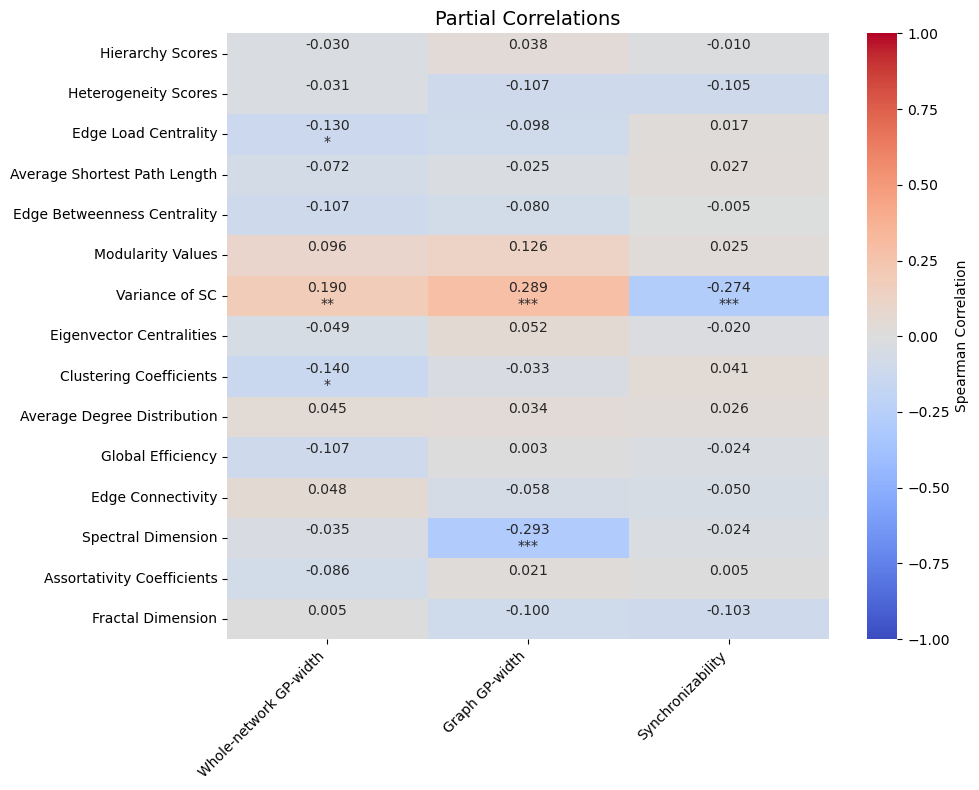

In [67]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list

# Prepare control properties by excluding the property to be controlled for
def get_control_properties(properties, exclude_idx):
    control_properties = np.delete(properties, exclude_idx, axis=0)
    return np.transpose(control_properties)

# Function to get significance stars
def get_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Define a function to compute partial Spearman correlation
def partial_spearmanr(x, y, control):
    # Residualize x and y with respect to control
    control = np.atleast_2d(control)
    control = np.concatenate([np.ones((control.shape[0], 1)), control], axis=1)
    
    beta_x = np.linalg.lstsq(control, x, rcond=None)[0]
    beta_y = np.linalg.lstsq(control, y, rcond=None)[0]
    
    x_resid = x - control @ beta_x
    y_resid = y - control @ beta_y
    
    # Compute Spearman correlation on residuals
    return scipy.stats.spearmanr(x_resid, y_resid)

# Compute partial correlations, p-values, and significance stars
partial_correlations = []
p_values = []
stars = []

for i, sc_property in enumerate(sc_properties):
    sc_property = np.array(sc_property)  # Convert to numpy array for proper indexing
    control_properties = get_control_properties(sc_properties, i)
    
    partial_corr_gp_widths = partial_spearmanr(sc_property, gp_widths, control_properties)
    partial_corr_graph_gp_widths = partial_spearmanr(sc_property, graph_gp_widths, control_properties)
    partial_corr_synchronizability = partial_spearmanr(sc_property, synchronizability, control_properties)
    
    partial_correlations.append([partial_corr_gp_widths.correlation, partial_corr_graph_gp_widths.correlation, partial_corr_synchronizability.correlation])
    p_values.append([partial_corr_gp_widths.pvalue, partial_corr_graph_gp_widths.pvalue, partial_corr_synchronizability.pvalue])
    stars.append([get_significance_stars(partial_corr_gp_widths.pvalue), get_significance_stars(partial_corr_graph_gp_widths.pvalue), get_significance_stars(partial_corr_synchronizability.pvalue)])

partial_correlation_matrix = np.array(partial_correlations)
star_matrix = np.array(stars)

# Compute hierarchical clustering for SC properties
linkage_matrix = linkage(sc_property_matrix, method='average')
order = leaves_list(linkage_matrix)

# Sort the partial correlation matrix, star matrix, and property names based on the clustering order
sorted_partial_correlation_matrix = partial_correlation_matrix[order, :]
sorted_star_matrix = star_matrix[order, :]
sorted_sc_property_names = np.array(sc_property_names)[order]

# Create annotation labels combining correlation coefficients and significance stars
annot = np.empty_like(sorted_partial_correlation_matrix, dtype=object)
for i in range(sorted_partial_correlation_matrix.shape[0]):
    for j in range(sorted_partial_correlation_matrix.shape[1]):
        annot[i, j] = f'{sorted_partial_correlation_matrix[i, j]:.3f}\n{sorted_star_matrix[i, j]}'

# Plotting the partial correlation matrix with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_partial_correlation_matrix, annot=annot, fmt='', cmap='coolwarm', 
            xticklabels=['Whole-network GP-width', 'Graph GP-width', 'Synchronizability'], 
            yticklabels=sorted_sc_property_names, 
            cbar_kws={'label': 'Spearman Correlation'}, vmin=-1, vmax=1)

plt.title('Partial Correlations', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


NODAL ANALYSIS

In [5]:
# GP-widths for all subjects for nodes
# Load the peak K values for each subject
n_sub = 230
peak_k_data = []
for subject_index in range(n_sub):
    peak_k_data.append(np.load(f'/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/peak_ks_array_230/peak_ks_subject_{subject_index}.npy'))

# Compute GP widths for each subject
gp_widths_subjects = []
ks = np.linspace(1,8,40)
threshold = 0.65

for subject_index in range(n_sub):
    subject_data = peak_adj_dfa[subject_index, :, 0, 0:200]
    gp_widths_nodes = []
    max_dfa_indices = np.argmax(subject_data, axis=0)
    peak_ks = ks[max_dfa_indices]
    max_dfa_values = np.max(subject_data, axis=0)
    
    filtered_peak_ks = peak_ks[max_dfa_values > threshold]
    filtered_max_dfa_values = max_dfa_values[max_dfa_values > threshold]

    for parcel_index in range(subject_data.shape[1]):
        dfa_curve = subject_data[:, parcel_index]

        above_threshold = dfa_curve >= threshold

        if np.any(above_threshold):
            first_peak_index = np.argmax(above_threshold)
            last_peak_index = len(above_threshold) - np.argmax(above_threshold[::-1]) - 1

            peak_width = ks[last_peak_index] - ks[first_peak_index]

            gp_widths_nodes.append(peak_width)
        else:
            gp_widths_nodes.append(0)

    gp_widths_subjects.append(gp_widths_nodes)

gp_widths_subjects = np.array(gp_widths_subjects)
print(gp_widths_subjects.shape)

(230, 200)


In [6]:
# NODAL PLV --> NODAL SYNCHRONIZABILITIES
# CHECK THIS STILL, WHERE IS THE PEAK K NODAL PLV DATA?
region_plv = np.load('/m/nbe/scratch/leap_mcpsych/Samanta/kuramoto/all_subjects_array/plv_KL_orig_node.npy')
nodal_plv = np.mean(region_plv, axis=-1)  # Taking mean across the last axis to get nodal PLV (edge dimension)
synchronizabilities_nodes = np.zeros((nodal_plv.shape[0], nodal_plv.shape[-1]))

plv_value = 0.5
ks = np.linspace(1, 8, num=40)

for subject_index in range(nodal_plv.shape[0]):
    for node_index in range(nodal_plv.shape[-1]):
        plv_ks = np.zeros(nodal_plv.shape[1])  
        
        # Interpolate PLV values to get more accurate K-value where PLV = 0.5
        plv_interp_func = scipy.interpolate.interp1d(nodal_plv[subject_index, :, 0, node_index], ks, kind='linear')
        plv_ks = plv_interp_func(plv_value)
        
        synchronizabilities_nodes[subject_index, node_index] = plv_ks

print(synchronizabilities_nodes.shape)

(230, 200)


Node 106: GP-width - 1.26
Node 101: GP-width - 1.08


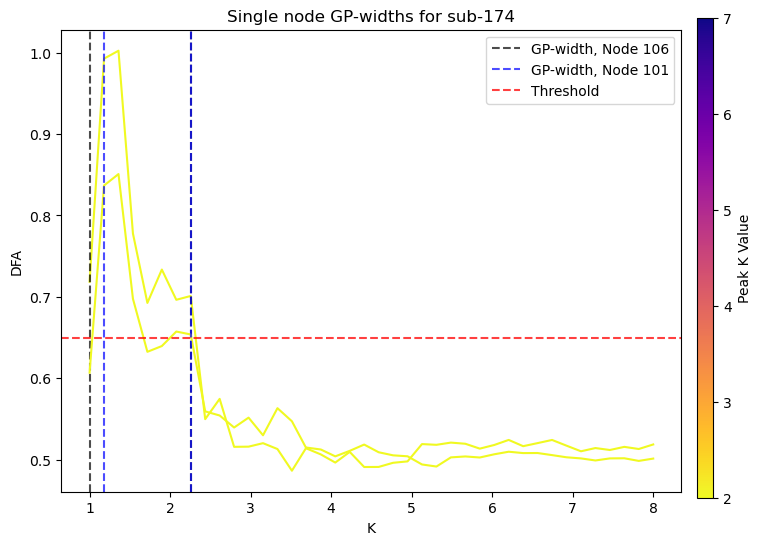

In [7]:
subject_index = 23  # Specify the subject index you want to visualize
subject_data = peak_adj_dfa[subject_index, :, 0, 0:200]  # Assuming 200 parcels

threshold = 0.65  # Define your threshold value here

max_dfa_indices = np.argmax(subject_data, axis=0)
peak_ks = ks[max_dfa_indices]
max_dfa_values = np.max(subject_data, axis=0)

filtered_peak_ks = peak_ks[max_dfa_values > threshold]
filtered_max_dfa_values = max_dfa_values[max_dfa_values > threshold]

cmap = plt.cm.plasma_r
norm = Normalize(vmin=2, vmax=7) 

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)  # Main plot axis
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Colorbar axis [left, bottom, width, height]

# Define nodes to plot and their respective colors
nodes_to_plot = [105, 100]  # Specify the nodes you want to plot
colors = ['black', 'blue']  # Specify the colors for each node

for i, parcel_index in enumerate(nodes_to_plot):
    peak_k = peak_ks[parcel_index]
    peak_dfa = max_dfa_values[parcel_index]
    
    if peak_dfa >= threshold:
        dfa_curve = subject_data[:, parcel_index]
        above_threshold = dfa_curve >= threshold
        above_threshold_indices = np.where(above_threshold)[0]
        
        if above_threshold_indices.size > 0:
            gp_width = ks[above_threshold_indices[-1]] - ks[above_threshold_indices[0]]
            print(f"Node {parcel_index+1}: GP-width - {gp_width:.2f}")
            
            ax.plot(ks, dfa_curve, color=cmap(norm(peak_k)), alpha=1)  # Use normalized K value for color
            
            ax.axvline(x=ks[above_threshold_indices[0]], color=colors[i], linestyle='--', alpha = 0.7, label=f'GP-width, Node {parcel_index+1}')  # Start of GP-width range
            ax.axvline(x=ks[above_threshold_indices[-1]], color=colors[i], linestyle='--', alpha = 0.7)  # End of GP-width range
        
    else:
        ax.plot(ks, subject_data[:, parcel_index], color='black', alpha=0.7)  # Plot in gray if peak DFA is below threshold

        
ax.set_xlabel('K')  
ax.set_ylabel('DFA')
ax.set_title(f'Single node GP-widths for sub-{clinical_ids[subject_index]}')
ax.axhline(threshold, color = 'red', label = 'Threshold', linestyle='--', alpha = 0.75)

ax.legend()  # Remove legend as it's not needed

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Peak K Value')

plt.show()


In [8]:
dgs_nodes = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/degree_centrality_nodes.npy')
ccs_nodes = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/closeness_centrality_nodes.npy')
pg_nodes = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/pagerank_nodes.npy')
lc_coeff_nodes = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/local_clustering_coeff_nodes.npy')
hubness = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/hub_nodes.npy')
eigcent_nodes = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/eigcent_nodes.npy')
node_strength = np.load('/m/nbe/scratch/leap_mcpsych/Aleksi/master_thesis/SC_properties/node_strength.npy')

In [9]:
dgs_nodes = np.array(dgs_nodes)
print(dgs_nodes.shape)
ccs_nodes = np.array(ccs_nodes)
print(ccs_nodes.shape)
pg_nodes = np.array(pg_nodes)
print(pg_nodes.shape)
lc_coeff_nodes = np.array(lc_coeff_nodes)
print(lc_coeff_nodes.shape)
hubness = np.array(hubness)
print(hubness.shape)
eigcent_nodes = np.array(eigcent_nodes)
print(eigcent_nodes.shape)
node_strength = np.array(node_strength)
print(node_strength.shape)

print(gp_widths_subjects.shape)

(230, 200)
(230, 200)
(230, 200)
(230, 200)
(230, 200)
(230, 200)
(230, 200)
(230, 200)


In [10]:
dgs_mean = np.mean(dgs_nodes, axis=(0, 1))
ccs_mean = np.mean(ccs_nodes, axis=(0, 1))
pg_mean = np.mean(pg_nodes, axis=(0, 1))
lc_coeff_mean = np.mean(lc_coeff_nodes, axis=(0, 1))
hubness_mean = np.mean(hubness, axis=(0, 1))
eigcent_mean = np.mean(eigcent_nodes, axis=(0, 1))
node_strength_mean = np.mean(node_strength, axis=(0, 1))

In [11]:
# Make a table of nodal SC metrics for thesis
df = pd.DataFrame({
    'Property': ['DGS Nodes', 'CCS Nodes', 'PG Nodes', 'LC Coeff Nodes', 'Hubness', 'Eigcent Nodes', 'Node Strength'],
    'Mean Value': [dgs_mean, ccs_mean, pg_mean, lc_coeff_mean, hubness_mean, eigcent_mean, node_strength_mean]
})

print(df)

         Property  Mean Value
0       DGS Nodes    0.912048
1       CCS Nodes    0.924295
2        PG Nodes    0.005000
3  LC Coeff Nodes    0.929141
4         Hubness    0.005000
5   Eigcent Nodes    0.070434
6   Node Strength  200.000000


In [12]:
nodal_measures = [
    (dgs_nodes, "Degree Centrality"),
    (ccs_nodes, "Closeness Centrality"),
    (pg_nodes, "Pagerank"),
    (lc_coeff_nodes, "Local Clustering Coefficient"),
    (hubness, "Hub values"),
    (eigcent_nodes, "Eigenvector centrality"),
    (node_strength, "Node Strength")
]

for nodes, measure_name in nodal_measures:
    nodes = np.nan_to_num(np.array(nodes))
    
    # Initialize lists to store correlation coefficients and p-values
    correlations = []
    p_values = []
    
    # Iterate over each node
    for node_index in range(nodes.shape[1]):
        # Extract nodal measure for the current node and replace NaNs with zeros
        nodal_measure = nodes[:, node_index]
        
        # Replace NaNs in gp_widths_subjects with zeros
        gp_widths_subject = np.nan_to_num(gp_widths_subjects[:, node_index])
        
        # Compute Spearman correlation with graph widths for the current node
        correlation, p_value = scipy.stats.spearmanr(nodal_measure, gp_widths_subject)
        
        # Check for NaN values in correlation and p_value, and replace them with zero if necessary
        if np.isnan(correlation):
            correlation = 0
        if np.isnan(p_value):
            p_value = 1  # p-value of 1 indicates no correlation

        # Append the correlation coefficient and p-value to the lists
        correlations.append(correlation)
        p_values.append(p_value)
    
    # Convert lists to numpy arrays for saving
    correlations = np.array(correlations)
    p_values = np.array(p_values)
    
    # Save correlations to a numpy array file
    np.save(f"correlation_data/{measure_name.replace(' ', '_').lower()}_correlations.npy", correlations)
    
    # Print the correlation coefficients and corresponding p-values for the current nodal measure
    print(f"Nodal Measure: {measure_name}")
    for node_index, (correlation, p_value) in enumerate(zip(correlations, p_values)):
        print(f"Node {node_index}: Correlation = {correlation}, p-value = {p_value}")
    print()


/m/nbe/scratch/join-e3200-kuramoto/source/kuramoto_env/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Nodal Measure: Degree Centrality
Node 0: Correlation = -0.025841676652416, p-value = 0.6966561473122245
Node 1: Correlation = -0.08122345567029124, p-value = 0.21977305278865855
Node 2: Correlation = -0.18511747590529162, p-value = 0.004854497209207592
Node 3: Correlation = -0.18572417715361103, p-value = 0.004714384125933004
Node 4: Correlation = -0.03943477957071376, p-value = 0.5518226901708289
Node 5: Correlation = -0.22114543600242714, p-value = 0.0007315383837396647
Node 6: Correlation = 0.005034066557174253, p-value = 0.9394748544687812
Node 7: Correlation = -0.002118190806972275, p-value = 0.9745127502716114
Node 8: Correlation = 0.0, p-value = 1.0
Node 9: Correlation = 0.09926132430300028, p-value = 0.13338670343854536
Node 10: Correlation = -0.028399905937135844, p-value = 0.6683266801694909
Node 11: Correlation = -0.14491183291337875, p-value = 0.027996589394682407
Node 12: Correlation = -0.08796935878989512, p-value = 0.1837057259177961
Node 13: Correlation = -0.09569077641

(190,)
(190,)
(195,)
(193,)
(190,)
(190,)
(195,)


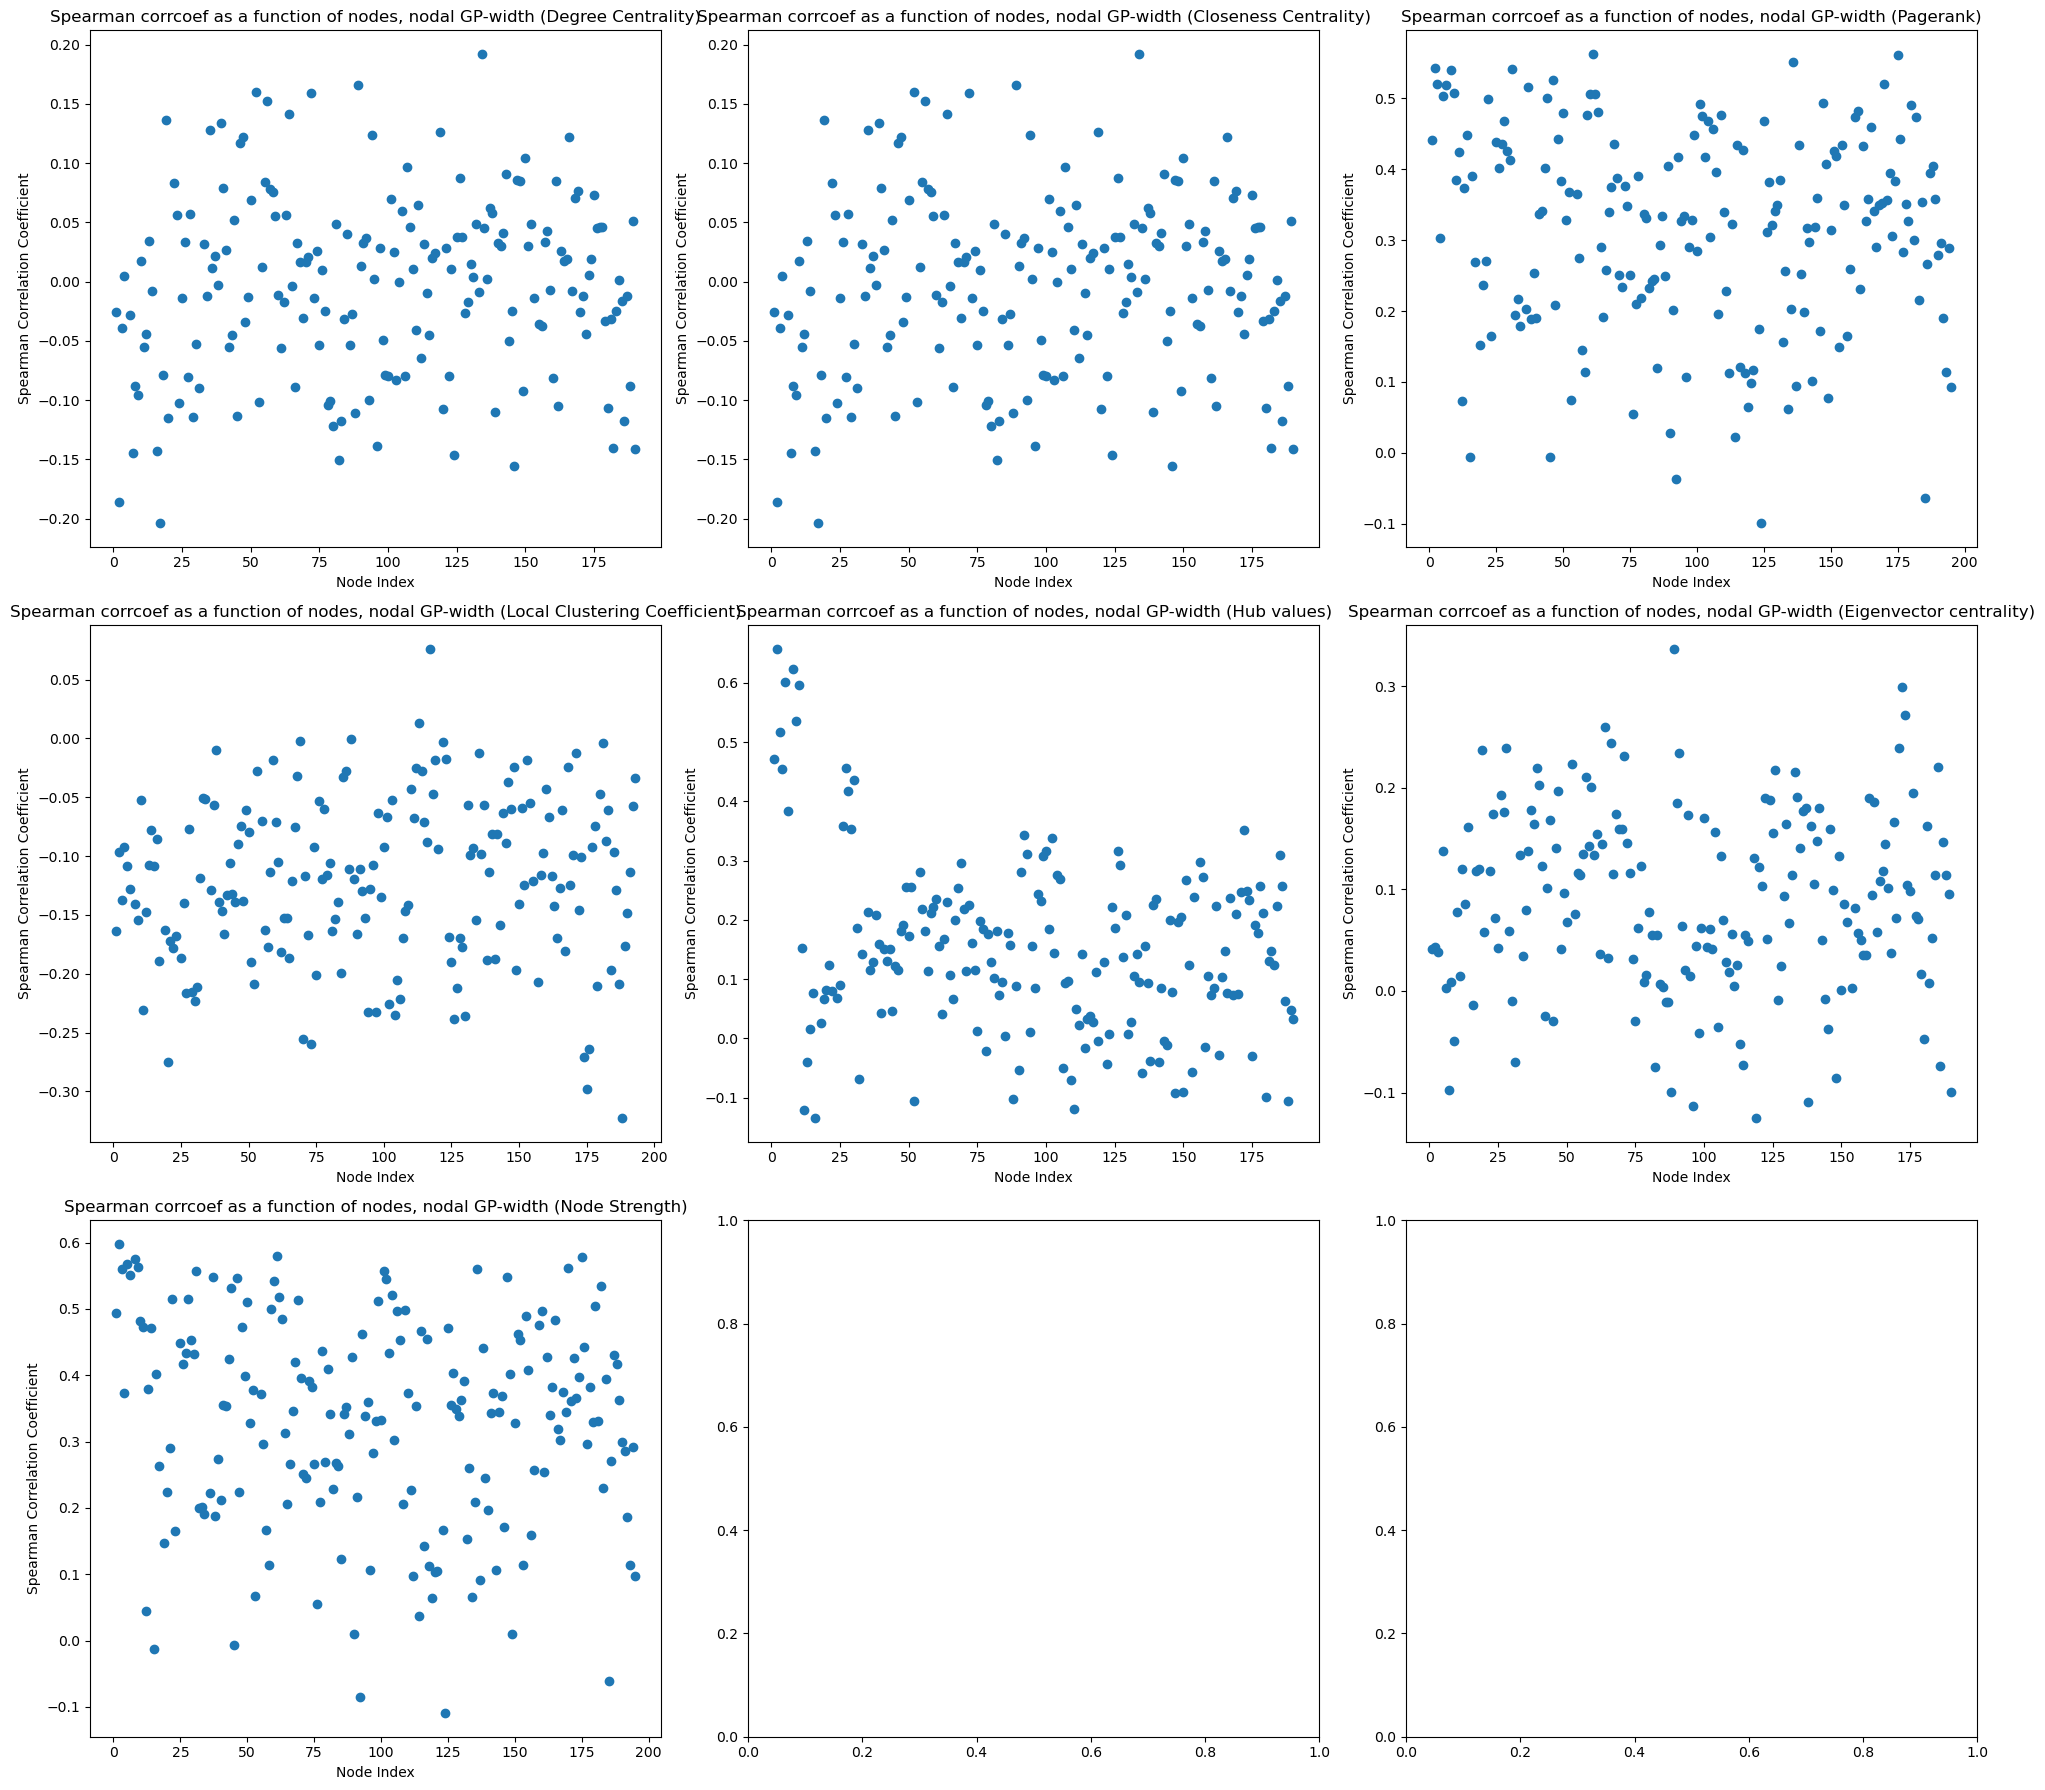

In [32]:
# Spearmann correlations for each node and SC property across all subjects for nodal GP-width
# and 5% of values closest to the p-value threshold removal
correlation_coefficients = {}

for nodes, measure_name in nodal_measures:
    nodes = np.array(nodes)
    
    # Initialize an empty list to store correlation coefficients for the current nodal measure
    measure_correlations = []
    
    # Iterate over each node
    for j in range(nodes.shape[1]):
        nodal_measure = nodes[:, j]
        
        # Compute Spearman correlation with graph widths for the current node
        correlation, p_value = scipy.stats.spearmanr(nodal_measure, gp_widths_subjects[:, j])
        
        measure_correlations.append(correlation)
    
    correlation_coefficients[measure_name] = measure_correlations

# Define a function to remove the 5% of values closest to the p-value threshold for positive and negative correlations
def remove_threshold(correlations, p_values):
    correlations_array = np.array(correlations)
    p_values_flat = np.array(p_values)
    N_fp = int(len(correlations) * 0.05 / 2)
    # Find indices of significant positive and negative correlations
    p_sig_pos = np.where((p_values_flat < 0.05) & (correlations_array > 0))[0]
    p_sig_neg = np.where((p_values_flat < 0.05) & (correlations_array < 0))[0]
    
    # Select the top N_fp significant positive and negative correlations
    selected_indices_pos = np.argsort(p_values_flat[p_sig_pos])[:N_fp]
    selected_indices_neg = np.argsort(p_values_flat[p_sig_neg])[:N_fp]
    
    # Remove the selected correlations from the array
    correlations_array = np.delete(correlations_array, p_sig_pos[selected_indices_pos])
    correlations_array = np.delete(correlations_array, p_sig_neg[selected_indices_neg])
    
    return correlations_array


fig, axs = plt.subplots(3, 3, figsize=(20, 18))

axs = axs.flatten()

# Iterate over each nodal measure and its correlation coefficients
for i, (measure_name, measure_correlations) in enumerate(correlation_coefficients.items()):
    filtered_correlations = remove_threshold(measure_correlations, p_values)
    print(filtered_correlations.shape)
    axs[i].scatter(range(1, len(filtered_correlations) + 1), filtered_correlations)
    axs[i].set_title(f'Spearman corrcoef as a function of nodes, nodal GP-width ({measure_name})')
    axs[i].set_xlabel('Node Index')
    axs[i].set_ylabel('Spearman Correlation Coefficient')

plt.tight_layout()
plt.show()

(190,)
(190,)
(190,)
(190,)
(190,)
(190,)
(190,)


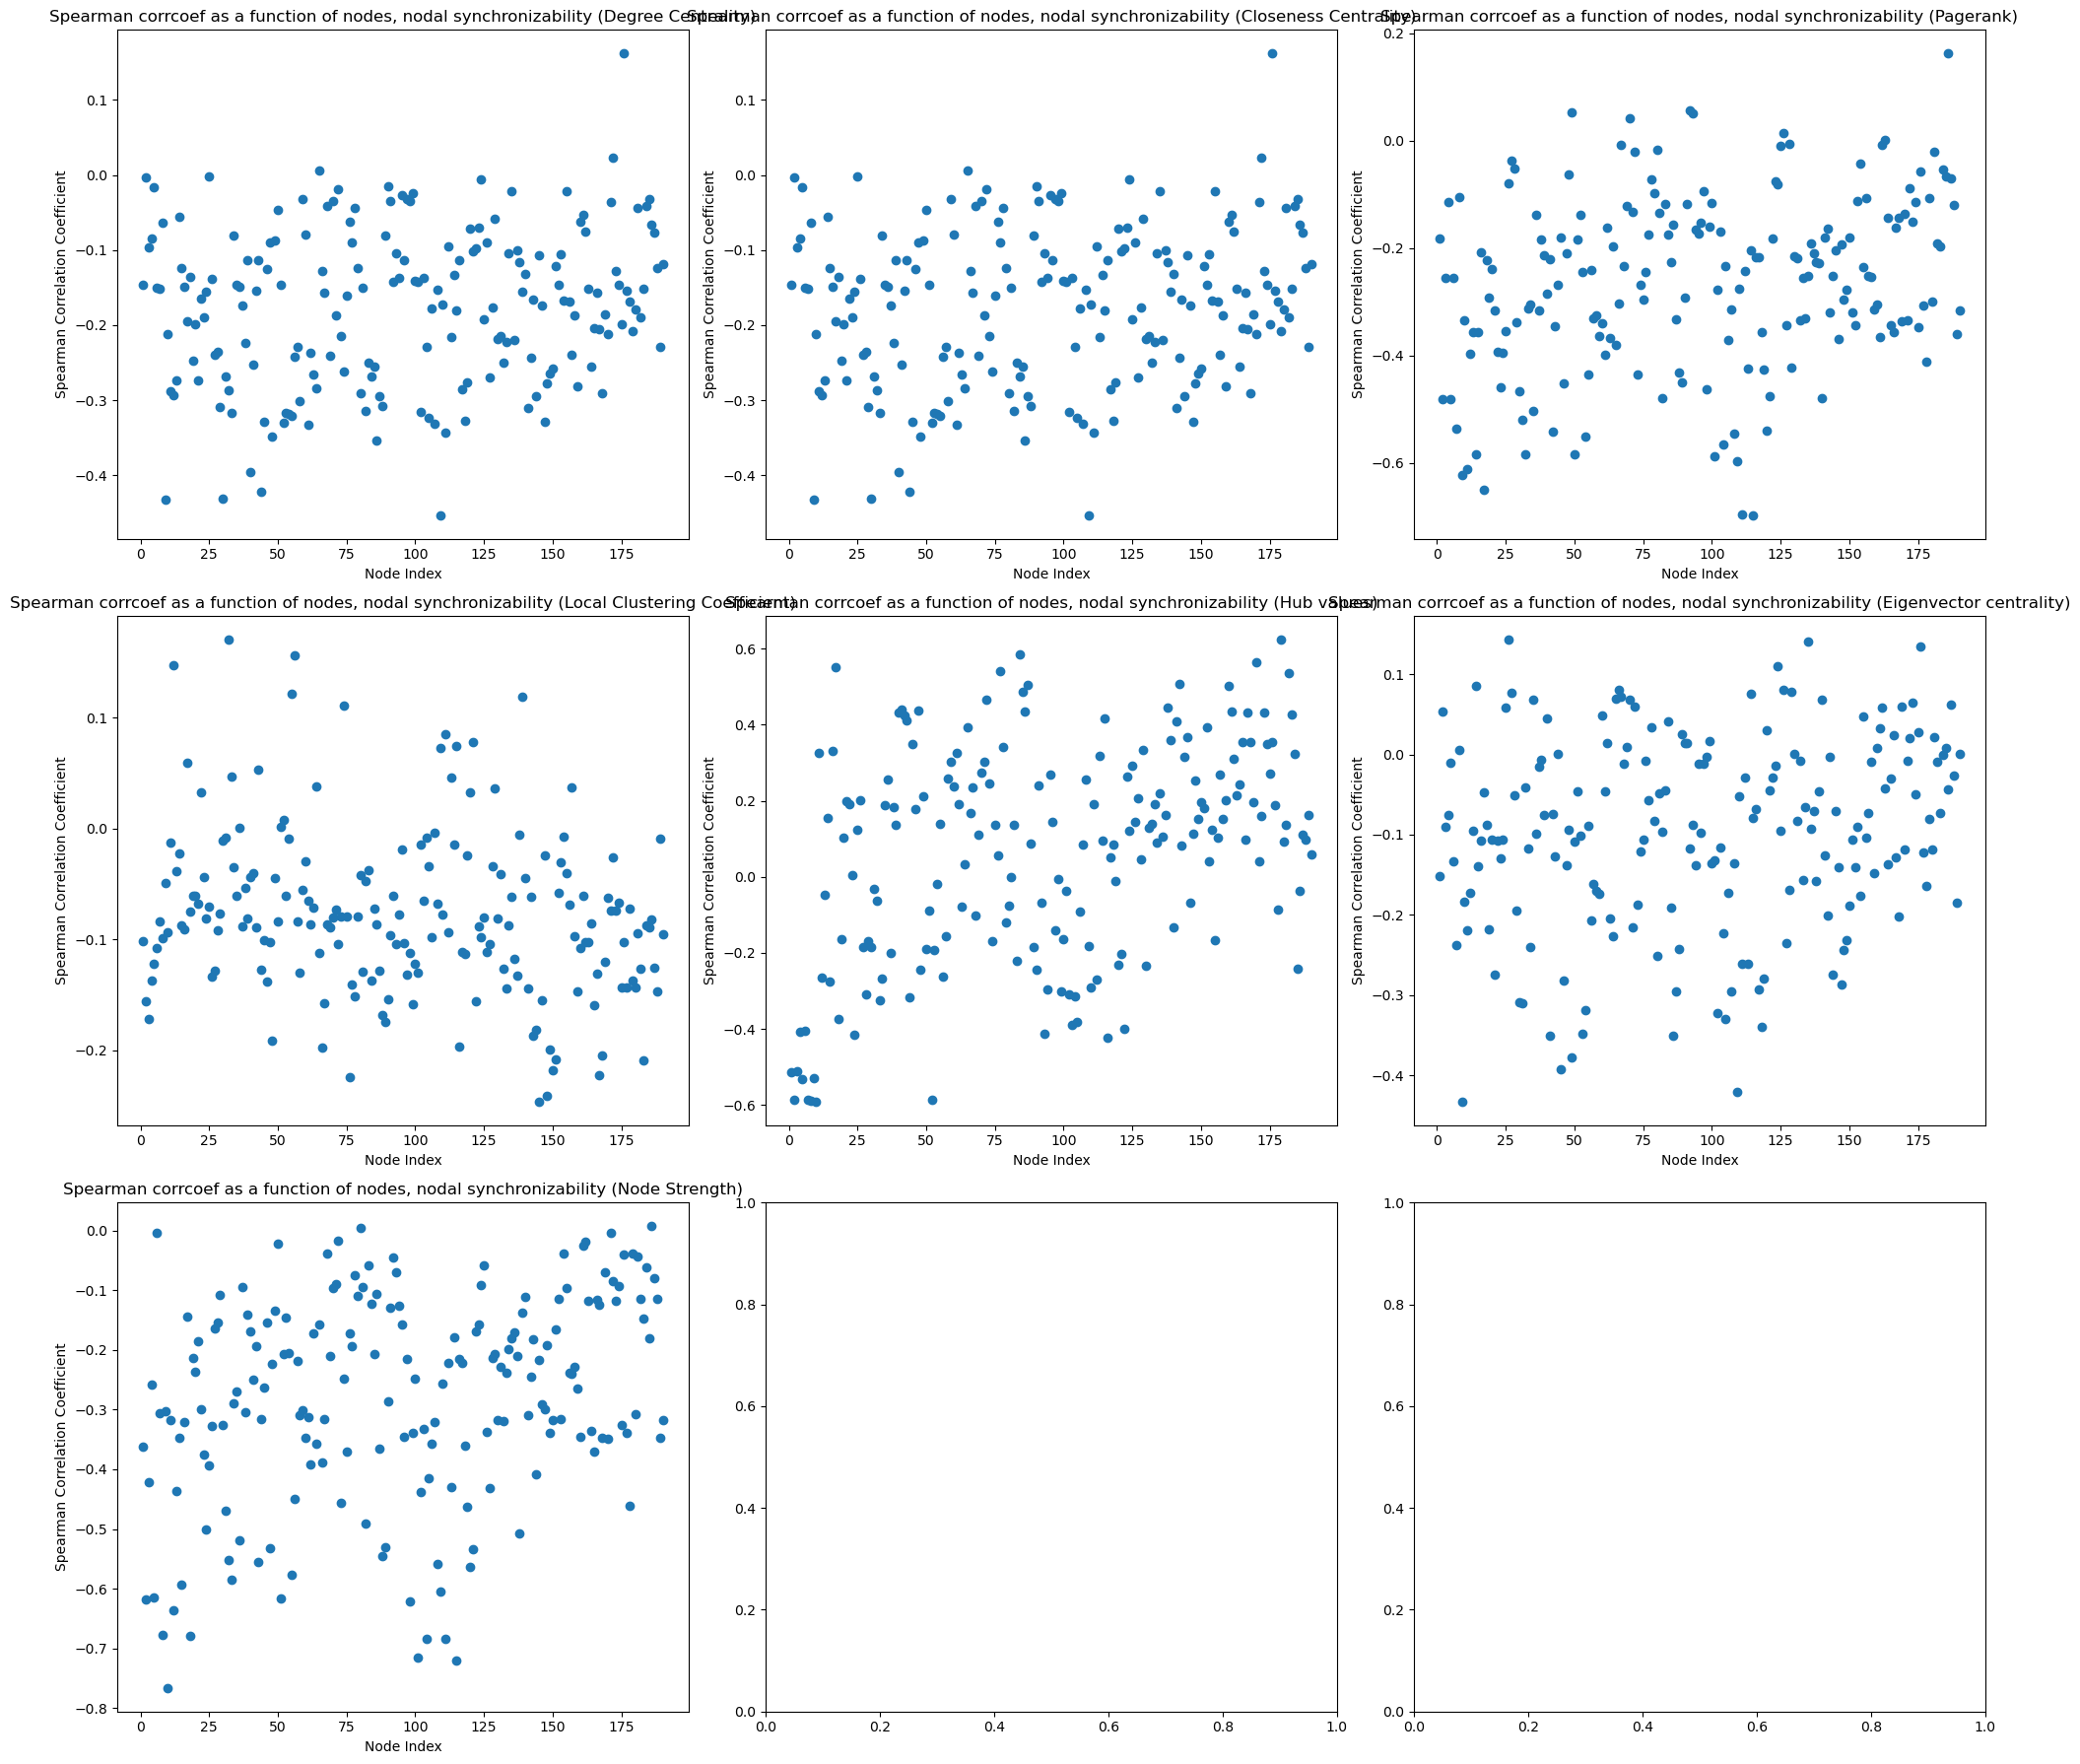

In [33]:
# Spearmann correlations for each node and SC property across all subjects for nodal synchronizability
# and 5% of values closest to the p-value threshold removal
correlation_coefficients = {}

for nodes, measure_name in nodal_measures:
    nodes = np.array(nodes)
    
    # Initialize an empty list to store correlation coefficients for the current nodal measure
    measure_correlations = []
    
    # Iterate over each node
    for j in range(nodes.shape[1]):
        nodal_measure = nodes[:, j]
        
        # Compute Spearman correlation with graph widths for the current node
        correlation, p_value = scipy.stats.spearmanr(nodal_measure, synchronizabilities_nodes[:, j])
        
        measure_correlations.append(correlation)
    
    correlation_coefficients[measure_name] = measure_correlations

# Define a function to remove the 5% of values closest to the p-value threshold for positive and negative correlations
def remove_threshold(correlations, p_values):
    correlations_array = np.array(correlations)
    p_values_flat = np.array(p_values)
    N_fp = int(len(correlations) * 0.05/2)
    
    # Find indices of significant positive and negative correlations
    p_sig_pos = np.where((p_values_flat < 0.05) & (correlations_array > 0))[0]
    p_sig_neg = np.where((p_values_flat < 0.05) & (correlations_array < 0))[0]
    
    # Select the top N_fp significant positive and negative correlations
    selected_indices_pos = np.argsort(p_values_flat[p_sig_pos])[:N_fp]
    selected_indices_neg = np.argsort(p_values_flat[p_sig_neg])[:N_fp]
    
    # Remove the selected correlations from the array
    correlations_array = np.delete(correlations_array, p_sig_pos[selected_indices_pos])
    correlations_array = np.delete(correlations_array, p_sig_neg[selected_indices_neg])
    
    return correlations_array


fig, axs = plt.subplots(3, 3, figsize=(20, 18))

axs = axs.flatten()

# Iterate over each nodal measure and its correlation coefficients
for i, (measure_name, measure_correlations) in enumerate(correlation_coefficients.items()):
    filtered_correlations = remove_threshold(measure_correlations, p_values)
    print(filtered_correlations.shape)
    axs[i].scatter(range(1, len(filtered_correlations) + 1), filtered_correlations)
    axs[i].set_title(f'Spearman corrcoef as a function of nodes, nodal synchronizability ({measure_name})')
    axs[i].set_xlabel('Node Index')
    axs[i].set_ylabel('Spearman Correlation Coefficient')

plt.tight_layout()
plt.show()